# Linear Regression

In [2]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt

pd.options.display.max_columns = 1000

%matplotlib inline

In [50]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

## Preprocessing

### Helper functions

#### Function to convert minutes to seconds

In [4]:
def calc_secs(x):
    return int(x.split(':')[0])*60 + int(x.split(':')[1])

In [5]:
def sql_to_df(table, year=''):
    
    if year:
        year_clean = '00' + year[0] + year[2:]
        select_statement = "select * from nba.{} where (GAME_ID REGEXP '(^{})') order by GAME_ID".format(table, year_clean)
    else:
        select_statement = "SELECT * FROM nba.{} order by GAME_ID;".format(table)
    
    cursor.execute(select_statement)
    data = cursor.fetchall()
    data_df = pd.DataFrame(data)
    
    field_names = [i[0] for i in cursor.description]
    data_df.columns = field_names
    
    return data_df

In [6]:
def join_date(data, year=''):
    date = sql_to_df('game_logs', year)
    
    total_with_date = data.merge(date[['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION']], on=['GAME_ID', 'TEAM_ABBREVIATION'])
    total_with_date['GAME_DATE'] = total_with_date['GAME_DATE'].astype('datetime64')
    
    players = []

    for player in total_with_date['PLAYER_ID'].unique():
        df = total_with_date[total_with_date['PLAYER_ID']==player]
        df['rest_days'] = df['GAME_DATE'].diff()
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

In [7]:
def join_set_columns(data, year=''):

    vegas = sql_to_df('vegas', year)
    
    total_with_date = data.merge(vegas[['line','total', 'game_id','team','site', 'date']], left_on=['GAME_ID', 'TEAM_ABBREVIATION'], 
                   right_on=['game_id', 'team'])
    
    total_with_date['date'] = total_with_date['date'].astype('datetime64')
    
    players = []

    for player in total_with_date['PLAYER_ID'].unique():
        df = total_with_date[total_with_date['PLAYER_ID']==player].sort_values(by='date')
        df['rest_days'] = df['date'].diff()
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

In [8]:
def join_set_columns_v2(data, year=''):

    vegas = sql_to_df('vegas', year)
    
    total_with_date = data.merge(vegas[['line','total', 'game_id','team','site', 'date', 'oteam']], left_on=['GAME_ID', 'TEAM_ABBREVIATION'], 
                   right_on=['game_id', 'team'])
    
    total_with_date['date'] = total_with_date['date'].astype('datetime64')
    
    players = []

    for player in total_with_date['PLAYER_ID'].unique():
        df = total_with_date[total_with_date['PLAYER_ID']==player].sort_values(by='date')
        df['rest_days'] = df['date'].diff()
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

### Aggregation functions

#### Function to calculate rolling statistics for players from box score data

In [9]:
def formated_player_stats(table, cols, year = '', lag = None):
    
    nba_df = sql_to_df(table, year)
    
    ### Drop games where players do not play
    nba_df_played = nba_df[nba_df['MIN'].notnull()]
    
    ### Calculate seconds played in a game
    nba_df_played['SEC'] = nba_df_played['MIN'].apply(lambda x : calc_secs(x))
    
    
    players = []
    cols = cols
    for player in nba_df_played['PLAYER_ID'].unique():
        df = nba_df_played[nba_df_played['PLAYER_ID']==player]
        df['game_number'] = df['GAME_ID'].expanding().count()
        for col in cols:
            df['expanding_{}'.format(col)] = df.expanding().mean()[col].shift(1)
            if lag:
                df['rolling_{}'.format(col+str(lag))] = df.rolling(lag).mean()[col].shift(1)
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

In [10]:
def formated_player_statsV2(table, cols, year = '', lag =[]):
    
    nba_df = sql_to_df(table, year)
    
    ### Drop games where players do not play
    nba_df_played = nba_df[nba_df['MIN'].notnull()]
    
    ### Calculate seconds played in a game
    nba_df_played['SEC'] = nba_df_played['MIN'].apply(lambda x : calc_secs(x))
    
    
    players = []
    cols = cols
    for player in nba_df_played['PLAYER_ID'].unique():
        df = nba_df_played[nba_df_played['PLAYER_ID']==player]
        df['game_number'] = df['GAME_ID'].expanding().count()
        for col in cols:
            df['expanding_{}'.format(col)] = df.expanding().mean()[col].shift(1)
            if lag:
                for num in lag:
                    df['rolling_{}'.format(col+str(num))] = df.rolling(num).mean()[col].shift(1)
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

#### Function to generate pre_transformed dataframe for upload into regression function. Must be a child of a join_set_columns function

In [11]:
def generate_pre_transformed(combined_df):
    drop_cols = ['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'SEC', 'game_id', 'game_number', 'team']
    pre_transform = combined_df.drop(drop_cols, axis=1).sort_values(by='date')
    pre_transform['rest_days'] = pre_transform['rest_days'].dt.days
    
    return pre_transform

In [12]:
def generate_pre_transformed_V2(combined_df):
    
    new_df = combined_df[combined_df['SEC'] > 300]
#     'PLAYER_ID','GAME_ID',
    drop_cols = ['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'SEC', 'game_id', 'game_number', 'team']
    pre_transform = new_df.drop(drop_cols, axis=1).sort_values(by='date')
    pre_transform['rest_days'] = pre_transform['rest_days'].dt.days
    
    pre_transform['START_POSITION'] = pre_transform['START_POSITION'].apply(lambda x: '1' if x  else '0')
    
    
    return pre_transform

In [150]:
generate_pre_transformed_V2(all_d_cluster1)

START_POSITION   PTS  expanding_SEC  rolling_SEC3  rolling_SEC5  \
4934               0   6.0    1247.166667   1035.000000        1236.6   
4936               1  12.0    1253.333333   1139.000000        1250.8   
4933               1  37.0    2008.000000   1907.000000        1945.8   
4935               1  12.0    1491.666667   1503.666667        1540.4   
4937               1   2.0    2076.000000   2081.333333        2109.4   
...              ...   ...            ...           ...           ...   
2521               1  14.0    1363.448718   1676.000000        1701.2   
2525               1  14.0    1648.805195   1320.666667        1544.8   
13485              1   0.0    1247.596491   2230.000000        1895.2   
4153               0   2.0     825.855263    792.000000         769.6   
4159               0  12.0    1310.350877   1072.333333         902.8   

       expanding_FGM  rolling_FGM3  rolling_FGM5  expanding_FGA  rolling_FGA3  \
4934        3.666667      3.666667           3.8       6.500000      6.666667   
4936        3.500000      4.000000           4.0       5.833333      6.333333   
4933       10.666667      9.000000           9.8      21.666667     18.000000   
4935        3.833333      4.333333           3.8      10.000000     10.000000   
4937        4.000000      4.666667           4.4       9.333333     10.000000   
...              ...           ...           ...            ...           ...   
2521        3.012821      3.000000           3.0       6.987179      6.000000   
2525        2.454545      2.000000           2.6       6.077922      6.333333   
13485       3.350877      9.666667           6.8       8.087719     18.000000   
4153        2.118421      2.000000           1.8       3.592105      2.333333   
4159        3.491228      4.333333           3.2       8.333333      9.000000   

       rolling_FGA5  expanding_FG_PCT  rolling_FG_PCT3  rolling_FG_PCT5  \
4934            6.6          0.572333         0.569667           0.5868   
4936            6.8          0.646833         0.597333           0.5762   
4933           20.2          0.489500         0.489333           0.4840   
4935            9.8          0.387500         0.447333           0.3922   
4937            9.6          0.466667         0.533333           0.5100   
...             ...               ...              ...              ...   
2521            7.6          0.432436         0.398667           0.3524   
2525            7.0          0.402636         0.383333           0.4108   
13485          14.2          0.366632         0.538667           0.4426   
4153            2.4          0.550013         0.889000           0.6834   
4159            7.4          0.386719         0.528000           0.4502   

       expanding_FG3M  rolling_FG3M3  rolling_FG3M5  expanding_FG3A  \
4934         0.333333       0.666667            0.4        0.666667   
4936         0.166667       0.000000            0.0        0.166667   
4933         4.833333       3.333333            4.4       10.666667   
4935         1.500000       1.666667            1.4        3.833333   
4937         2.000000       2.000000            2.2        5.166667   
...               ...            ...            ...             ...   
2521         2.102564       2.333333            2.2        4.974359   
2525         1.402597       1.666667            2.2        3.571429   
13485        0.736842       1.333333            0.8        2.649123   
4153         0.000000       0.000000            0.0        0.000000   
4159         1.157895       1.000000            0.6        3.491228   

       rolling_FG3A3  rolling_FG3A5  expanding_FG3_PCT  rolling_FG3_PCT3  \
4934        0.666667            0.8           0.166667          0.333333   
4936        0.000000            0.0           0.166667          0.000000   
4933        8.666667           10.2           0.437333          0.373000   
4935        3.666667            3.8           0.375000          0.472333   
4937        5.333333  

#### Function to calculate rolling team statistics

In [13]:
def formatted_team_stats(table, cols, year = '', lag = None):
    
    pull = sql_to_df(table, year)
    
    teams_df = []
    cols = cols
    ### For every team, calculate the expanding mean for the given columns passed into the function, 
    ### and the the difference between the statistic in the game and the expanding mean leading up to that game
    ### Answers the question "how did a team perform compared to its average going into the game"
    for team in pull['TEAM_ID'].unique():
        df = pull[pull['TEAM_ID']==team]
        df['game_number'] = df['GAME_ID'].expanding().count()
        for col in cols:
            df['expanding_{}'.format(col)] = df.expanding().mean()[col].shift(1)
            df['difference_{}'.format(col)] = df[col] - df['expanding_{}'.format(col)]
            ### Add ability to see how team performs compared to their rolling average over a set of games
            ### Answers question "how did a team perform compared to its average over previous x number of games"
            if lag:
                df['rolling_{}'.format(col+str(lag))] = df.rolling(lag).mean()[col].shift(1)
                df['lag_difference_{}'.format(col)] = df[col] - df['rolling_{}'.format(col+str(lag))]
            continue
        df.dropna(inplace=True)
        teams_df.append(df)
        
        
    return pd.concat(teams_df)

#### Function to run regression given a pre_transformed combined dataframe

In [14]:
def do_regression(df, vars_to_transform):
    
    train_size = int(round(df.shape[0]*(2/3),0))
    test_size = int(round(df.shape[0]*(1/3),0))
    
    
    train = df.iloc[:train_size, :]
    test = df.iloc[:test_size, :]
    
    train_copy = train.copy()

    variables_to_transfrom = vars_to_transform
    scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
    
    train_copy[variables_to_transfrom] = scaler.fit_transform(train[variables_to_transfrom])
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    train_copy.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);
    
    corr_train = train_copy.corr()
    fig = plt.figure(figsize = (15, 12))
    ax = fig.gca()
    sns.heatmap(corr_train, ax = ax)
    
    outcome = 'PTS'
    predictors = train_copy.drop(labels=['PTS', 'date'], axis=1)
    pred_sum = "+".join(predictors.columns)
    formula = outcome + "~" + pred_sum
    
    model = ols(formula=formula, data=train_expanding_only.drop('date', axis=1)).fit()
    
    print(model.summary2())
    
    test_expanding_only = test.copy()
    test_expanding_only[variables_to_transfrom] = scaler.transform(test[variables_to_transfrom])
    
    prediction = pd.DataFrame(model.predict(test_expanding_only))
    merged = prediction.merge(test_expanding_only[['PTS']], left_on=prediction.index, right_on=test_expanding_only.index)
    merged.index = merged['key_0']
    merged.drop('key_0', axis=1, inplace=True)
    
    y_pred_df = prediction.merge(test_expanding_only.drop('PTS', axis=1), 
                 left_on= prediction.index, right_on= test_expanding_only.index).set_index('key_0', drop=True)
    
    y_pred_df.columns = ['PTS' if x == 0 else x for x in y_pred_df.columns ]
    y_pred_reg = y_pred_df.copy()
    
    y_pred_reg.columns = ['PTS' if x == 0 else x for x in y_pred_reg.columns ]
    
    y_pred_reg[variables_to_transfrom] = scaler.inverse_transform(y_pred_df[variables_to_transfrom])
    
    print(sqrt(mean_squared_error(test.PTS, y_pred_reg.PTS)))


#### Update to the function above to run regression using a pre_transformed dataframe- use this one

In [15]:
## use cols must include date and target variable PTS
## variables to transform must be a subset of use_cols
def do_regression_v2(pre_transformed_df, use_cols, vars_to_transform):
    
    
    df = pre_transformed_df[use_cols]
    
    train_size = int(round(df.shape[0]*(2/3),0))
    test_size = int(round(df.shape[0]*(1/3),0))
    
    train = df.iloc[:train_size, :]
    test = df.iloc[:test_size, :]
    
    train_copy = train.copy()

    variables_to_transfrom = vars_to_transform
    scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
    
    train_copy[variables_to_transfrom] = scaler.fit_transform(train[variables_to_transfrom])
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    train_copy.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);
    
    corr_train = train_copy.corr()
    fig = plt.figure(figsize = (15, 12))
    ax = fig.gca()
    sns.heatmap(corr_train, ax = ax)
    
    outcome = 'PTS'
    predictors = train_copy.drop(labels=['PTS', 'date'], axis=1)
    pred_sum = "+".join(predictors.columns)
    formula = outcome + "~" + pred_sum
    
    model = ols(formula=formula, data=train_copy.drop('date', axis=1)).fit()
    
    print(model.summary2())
    
    test_expanding_only = test.copy()
    test_expanding_only[variables_to_transfrom] = scaler.transform(test[variables_to_transfrom])
    
    prediction = pd.DataFrame(model.predict(test_expanding_only))
    merged = prediction.merge(test_expanding_only[['PTS']], left_on=prediction.index, right_on=test_expanding_only.index)
    merged.index = merged['key_0']
    merged.drop('key_0', axis=1, inplace=True)
    
    y_pred_df = prediction.merge(test_expanding_only.drop('PTS', axis=1), 
                 left_on= prediction.index, right_on= test_expanding_only.index).set_index('key_0', drop=True)
    
    y_pred_df.columns = ['PTS' if x == 0 else x for x in y_pred_df.columns ]
    y_pred_reg = y_pred_df.copy()
    
    y_pred_reg.columns = ['PTS' if x == 0 else x for x in y_pred_reg.columns ]
    
    y_pred_reg[variables_to_transfrom] = scaler.inverse_transform(y_pred_df[variables_to_transfrom])
    
    rmse = sqrt(mean_squared_error(test.PTS, y_pred_reg.PTS))
    
    print("Root Mean Squared Error: {}".format(round(rmse,4)))


### Generate train test split groups for regression trees

In [16]:
### accepts pre_transformed df with no columns allowed that are not used in model
def train_test(df, target, to_drop=[]):
    train_size = int(round(df.shape[0]*(2/3),0))
    test_size = int(round(df.shape[0]*(1/3),0))
    
    train = df.iloc[:train_size, :]
    test = df.iloc[:test_size, :]
    
#     drop = to_drop.append(target)
    
    X_train = train.drop(labels=target, axis=1)
    y_train = train[target]
    
    X_test = test.drop(labels=target, axis=1)
    y_test = test[target]
    
    return X_train, y_train, X_test, y_test

## Modeling

In [17]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
playerstats_2018 = formated_player_stats('box_score', cols = cols, year='2018')
combined = join_set_columns(playerstats_2018, year='2018')

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [18]:
drop_cols = ['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'SEC', 'game_id', 'game_number', 'team']
pre_transform = combined.drop(drop_cols, axis=1).sort_values(by='date')

In [19]:
pre_test = generate_pre_transformed(combined)

In [20]:
pre_transform

PTS  expanding_SEC  expanding_FGM  expanding_FGA  expanding_FG_PCT  \
9      10.0    1492.000000       3.500000       8.500000          0.393000   
19375  10.0    1121.000000       4.500000       7.000000          0.666500   
19376  31.0    1712.000000       3.000000       8.000000          0.366500   
19377   5.0     991.500000       2.500000       6.500000          0.393000   
19372  28.0    1617.000000       3.000000       9.000000          0.375000   
...     ...            ...            ...            ...               ...   
12526  20.0    1792.566667       7.616667      13.600000          0.557900   
12527   7.0     575.297872       1.319149       3.276596          0.318404   
20567   2.0     433.000000       1.333333       2.666667          0.404833   
12528   2.0     864.625000       1.875000       2.750000          0.506250   
6048    0.0    1121.650794       2.507937       5.269841          0.458952   

       expanding_FG3M  expanding_FG3A  expanding_FG3_PCT  expanding_FTM  \
9            1.500000        2.500000           0.583500       1.000000   
19375        0.500000        2.000000           0.250000       2.000000   
19376        1.500000        2.000000           0.750000       2.500000   
19377        1.000000        2.000000           0.250000       0.000000   
19372        0.000000        1.500000           0.000000       4.000000   
...               ...             ...                ...            ...   
12526        0.900000        2.600000           0.292500       3.333333   
12527        0.489362        1.617021           0.204617       0.510638   
20567        0.500000        1.000000           0.166667       0.333333   
12528        0.000000        0.125000           0.000000       0.500000   
6048         0.253968        0.746032           0.164016       1.507937   

       expanding_FTA  expanding_FT_PCT  expanding_PTS  line  total  site  \
9           1.000000          0.500000       9.500000  -9.0  210.5  away   
19375       3.000000          0.333500      11.500000  -3.0  219.0  away   
19376       2.500000          1.000000      10.000000  -3.0  219.0  away   
19377       0.000000          0.000000       6.000000  -3.0  219.0  away   
19372       4.000000          1.000000      10.000000  -3.0  219.0  away   
...              ...               ...            ...   ...    ...   ...   
12526       4.366667          0.701650      19.466667  -2.0  226.0  home   
12527       0.702128          0.234064       3.638298  -2.0  226.0  home   
20567       0.333333          0.166667       3.500000   5.0  229.0  away   
12528       1.000000          0.250000       4.250000  -2.0  226.0  home   
6048        1.952381          0.455206       6.777778  -2.5  219.0  home   

            date rest_days  
9     2018-10-20    1 days  
19375 2018-10-20    1 days  
19376 2018-10-20    1 days  
19377 2018-10-20    1 days  
19372 2018-10-20    1 days  
...          ...       ...  
12526 2019-04-10    5 days  
12527 2019-04-10    3 days  
20567 2019-04-10   22 days  
12528 2019-04-10    3 days  
6048  2019-04-10    5 days  

[25054 rows x 17 columns]

In [162]:
pre_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25054 entries, 9 to 6048
Data columns (total 17 columns):
PTS                  25054 non-null float64
expanding_SEC        25054 non-null float64
expanding_FGM        25054 non-null float64
expanding_FGA        25054 non-null float64
expanding_FG_PCT     25054 non-null float64
expanding_FG3M       25054 non-null float64
expanding_FG3A       25054 non-null float64
expanding_FG3_PCT    25054 non-null float64
expanding_FTM        25054 non-null float64
expanding_FTA        25054 non-null float64
expanding_FT_PCT     25054 non-null float64
expanding_PTS        25054 non-null float64
line                 25054 non-null float64
total                25054 non-null float64
site                 25054 non-null object
date                 25054 non-null datetime64[ns]
rest_days            25054 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(14), object(1), timedelta64[ns](1)
memory usage: 3.4+ MB


In [163]:
pre_transform['rest_days'] = pre_transform['rest_days'].dt.days

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



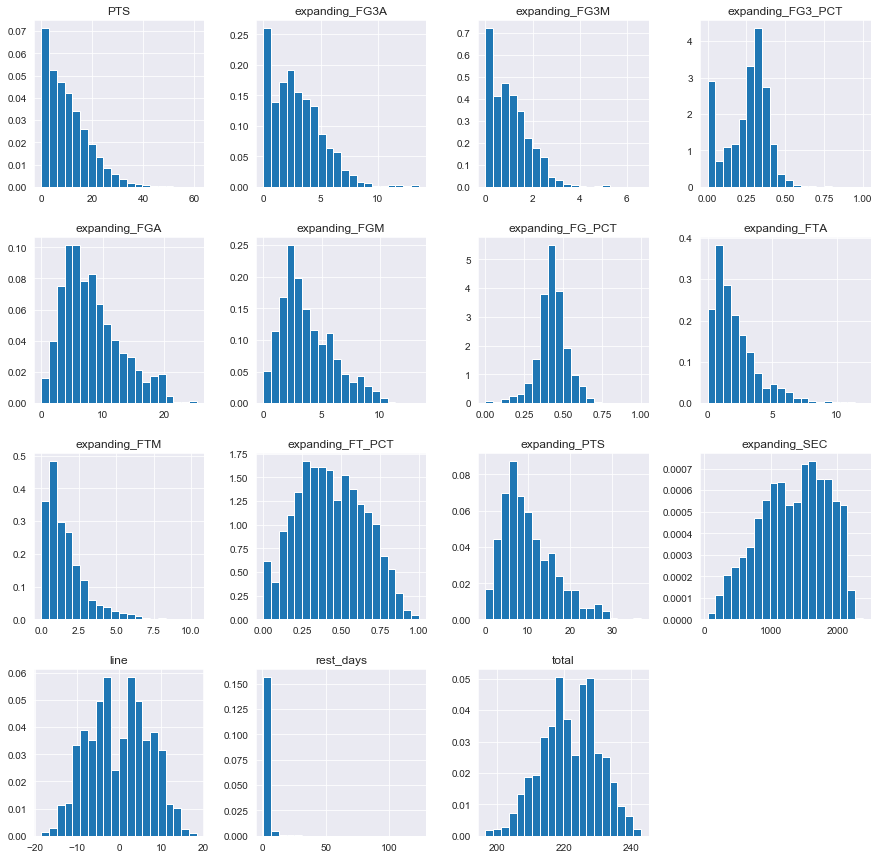

In [164]:

fig = plt.figure(figsize=(15,15))
ax = fig.gca()
pre_transform.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);


### Select only 2/3 of the season to build the model and transform the variables on. Test on the end of the season

In [167]:
train_size = int(round(combined.shape[0]*(2/3),0))
test_size = int(round(combined.shape[0]*(1/3),0))

train_size + test_size

25054

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.475     
Dependent Variable: PTS              AIC:                36649.1287
Date:               2020-01-16 10:55 BIC:                36772.7022
No. Observations:   16703            Log-Likelihood:     -18309.   
Df Model:           15               F-statistic:        1009.     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.476            Scale:              0.52484   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.2092   0.1558 -1.3433 0.1792 -0.5146  0.0961
site[T.home]         0.0215   0.0122  1.7594 0.0785 -0.0025  0.0455
expanding_SEC        0.0740   0.0138  5.3433 0.0000  0.0468  0.1011
expanding_FGM        0.5534   0.0926  5.9764 0.0000  0.3719  0.734

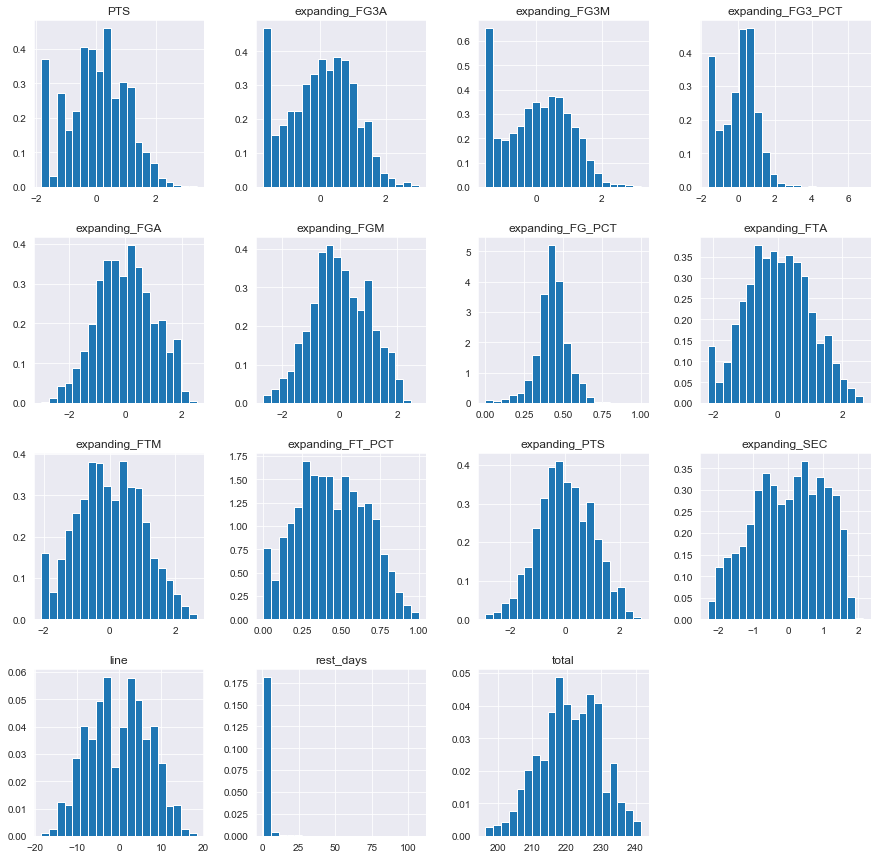

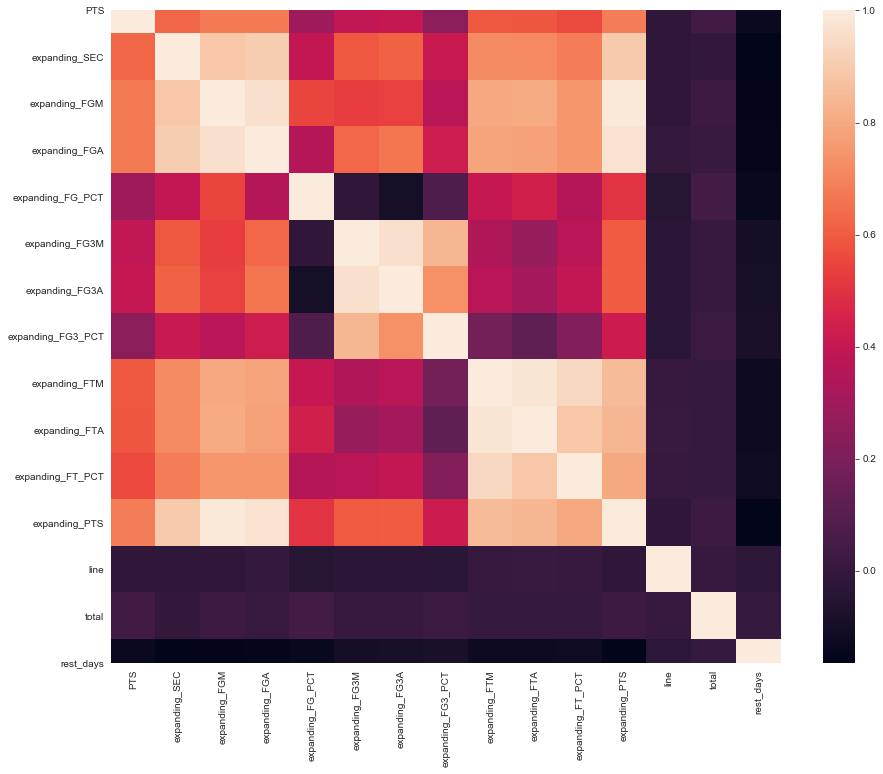

In [240]:
use_cols = pre_test.columns
transform = ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS']
do_regression_v2(pre_test, use_cols=use_cols, vars_to_transform=transform)

In [222]:
pre_test.columns

Index(['PTS', 'expanding_SEC', 'expanding_FGM', 'expanding_FGA',
       'expanding_FG_PCT', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FTM', 'expanding_FTA',
       'expanding_FT_PCT', 'expanding_PTS', 'line', 'total', 'site', 'date',
       'rest_days'],
      dtype='object')

#### Expanding features, dropping columns with p values above threshold from baseline model - 5.96

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.469     
Dependent Variable: PTS              AIC:                36854.8192
Date:               2020-01-16 11:02 BIC:                36932.0526
No. Observations:   16703            Log-Likelihood:     -18417.   
Df Model:           9                F-statistic:        1637.     
Df Residuals:       16693            Prob (F-statistic): 0.00      
R-squared:          0.469            Scale:              0.53153   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.8634   0.1427 -6.0516 0.0000 -1.1430 -0.5837
expanding_SEC        0.0708   0.0136  5.2053 0.0000  0.0442  0.0975
expanding_FGA        0.5119   0.0170 30.1332 0.0000  0.4786  0.5452
expanding_FG3M       0.1973   0.0316  6.2416 0.0000  0.1353  0.259

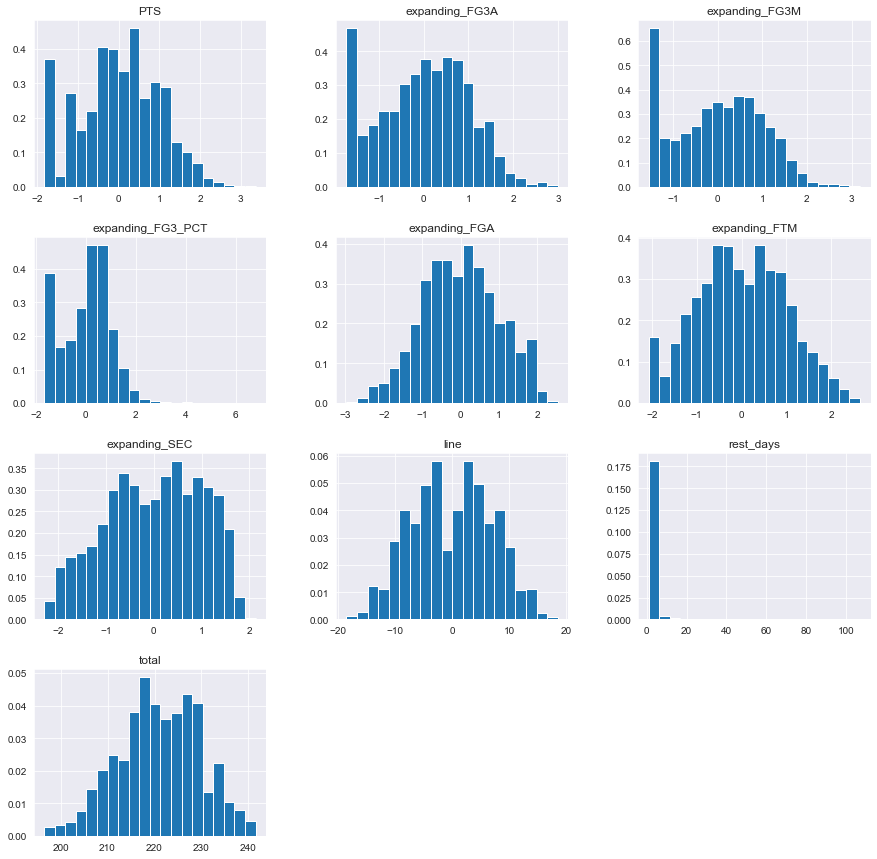

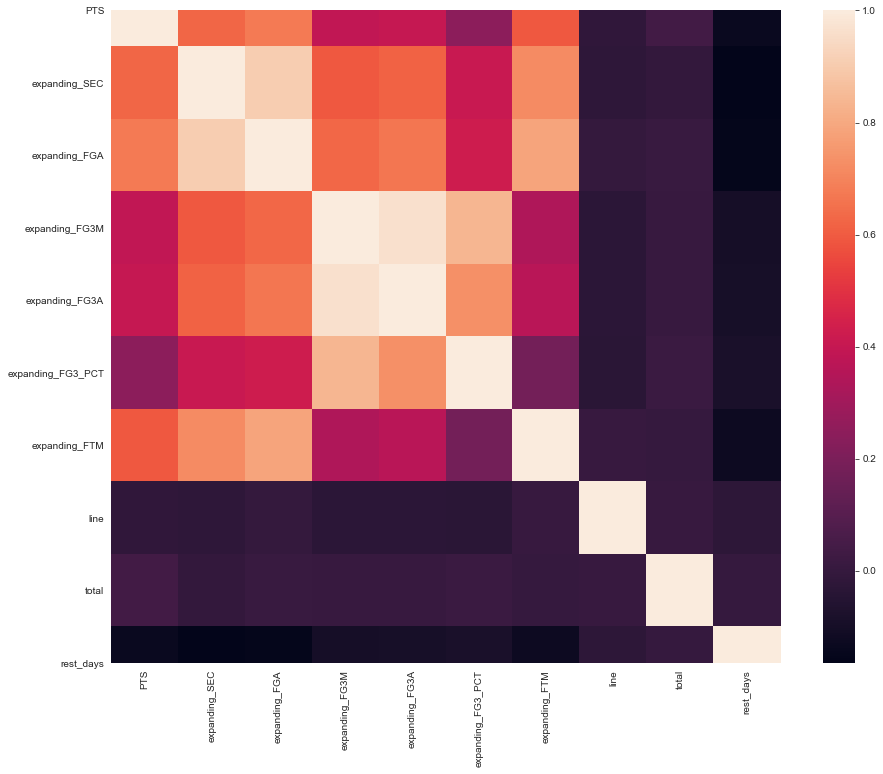

In [245]:
use_cols = ['PTS', 'expanding_SEC',  'expanding_FGA',
        'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FTM', 
         'line', 'total', 'date',
       'rest_days']
transform = ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT',  'expanding_FGA','expanding_FTM', 'expanding_SEC', 
        'expanding_FGA','expanding_FTM', 'expanding_SEC' ]
do_regression_v2(pre_test, use_cols=use_cols, vars_to_transform=transform)

In [229]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
lag_3 = formated_player_stats('box_score', cols = cols, year='2018', lag=3)
combined = join_set_columns(lag_3, year='2018')

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [230]:
combined.head()

GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
7   0021800065  1610612738               BOS    Boston    1626179   
17  0021800074  1610612738               BOS    Boston    1626179   
28  0021800099  1610612738               BOS    Boston    1626179   
38  0021800115  1610612738               BOS    Boston    1626179   
48  0021800127  1610612738               BOS    Boston    1626179   

     PLAYER_NAME START_POSITION COMMENT    MIN  FGM   FGA  FG_PCT  FG3M  FG3A  \
7   Terry Rozier                         24:57  2.0   5.0   0.400   0.0   2.0   
17  Terry Rozier                         27:21  4.0   8.0   0.500   2.0   3.0   
28  Terry Rozier                         19:28  1.0   4.0   0.250   0.0   1.0   
38  Terry Rozier                         26:09  3.0  11.0   0.273   1.0   4.0   
48  Terry Rozier                         18:56  2.0   5.0   0.400   2.0   4.0   

    FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK   PF   PTS  \
7     0.000  0.0  0.0     0.0   0.0   3.0  3.0  4.0  4.0  0.0  1.0   4.0   
17    0.667  4.0  4.0     1.0   0.0   8.0  8.0  2.0  0.0  0.0  2.0  14.0   
28    0.000  1.0  2.0     0.5   0.0   1.0  1.0  2.0  2.0  1.0  0.0   3.0   
38    0.250  0.0  0.0     0.0   0.0   7.0  7.0  3.0  0.0  2.0  4.0   7.0   
48    0.500  1.0  2.0     0.5   0.0   6.0  6.0  3.0  0.0  0.0  0.0   7.0   

    PLUS_MINUS                 pk  TOS SEASON_ID  DK_PTS  DD  TD  doubles  \
7          3.0  00218000651626179  0.0     22018   21.75   0   0      0.0   
17        15.0  00218000741626179  0.0     22018   28.00   0   0      1.0   
28         5.0  00218000991626179  1.0     22018   12.75   0   0      0.0   
38       -12.0  00218001151626179  1.0     22018   24.25   0   0      0.0   
48        -9.0  00218001271626179  1.0     22018   19.50   0   0      0.0   

     SEC  game_number  expanding_SEC  rolling_SEC3  expanding_FGM  \
7   1497          5.0    1321.250000   1231.333333       3.250000   
17  1641          6.0    1356.400000   1266.000000       3.000000   
28  1168          7.0    1403.833333   1355.666667       3.166667   
38  1569          8.0    1370.142857   1435.333333       2.857143   
48  1136          9.0    1395.000000   1459.333333       2.875000   

    rolling_FGM3  expanding_FGA  rolling_FGA3  expanding_FG_PCT  \
7       2.666667       8.500000      8.000000          0.377000   
17      2.666667       7.800000      7.333333          0.381600   
28      2.666667       7.833333      7.333333          0.401333   
38      2.333333       7.285714      5.666667          0.379714   
48      2.666667       7.750000      7.666667          0.366375   

    rolling_FG_PCT3  expanding_FG3M  rolling_FG3M3  expanding_FG3A  \
7          0.336000        1.500000       1.666667        3.500000   
17         0.374000        1.200000       1.000000        3.200000   
28         0.374000        1.333333       1.000000        3.166667   
38         0.383333        1.142857       0.666667        2.857143   
48         0.341000        1.125000       1.000000        3.000000   

    rolling_FG3A3  expanding_FG3_PCT  rolling_FG3_PCT3  expanding_FTM  \
7        4.000000           0.466750          0.455667          0.500   
17       3.666667           0.373400          0.233333          0.400   
28       3.333333           0.422333          0.289000          1.000   
38       2.000000           0.362000          0.222333          1.000   
48       2.666667           0.348000          0.305667          0.875   

    rolling_FTM3  expanding_FTA  rolling_FTA3  expanding_FT_PCT  \
7       0.666667       0.500000      0.666667          0.250000   
17      0.000000       0.400000      0.000000          0.200000   
28      1.333333       1.000000      1.333333          0.333333   
38      1.666667       1.142857      2.000000          0.357143   
48      1.666667       1.000000      2.000000          0.312500   

    rolling_FT_PCT3  expanding_PTS  rolling_PTS3  line  total     game_id  \
7          0.333333       8

In [232]:
pre_test2 = generate_pre_transformed(combined)
pre_test2.head()

PTS  expanding_SEC  rolling_SEC3  expanding_FGM  rolling_FGM3  \
5110    7.0         898.25    952.333333           3.00      3.000000   
824    19.0        1851.75   1873.666667           7.50      7.666667   
2626    2.0        1077.00   1074.666667           3.25      2.666667   
7720   10.0        1504.50   1598.666667           4.75      5.000000   
18696   4.0        1002.00    855.000000           3.50      3.333333   

       expanding_FGA  rolling_FGA3  expanding_FG_PCT  rolling_FG_PCT3  \
5110            5.50      5.666667           0.54175         0.522333   
824            17.25     17.333333           0.42625         0.431000   
2626            5.00      3.000000           0.78050         0.889000   
7720           10.00     10.666667           0.48750         0.483333   
18696           5.25      4.333333           0.68750         0.750000   

       expanding_FG3M  rolling_FG3M3  expanding_FG3A  rolling_FG3A3  \
5110             0.50       0.666667            1.00       1.000000   
824              4.25       5.000000            9.75      10.333333   
2626             0.00       0.000000            0.00       0.000000   
7720             0.50       0.666667            2.00       2.666667   
18696            0.25       0.333333            1.25       1.000000   

       expanding_FG3_PCT  rolling_FG3_PCT3  expanding_FTM  rolling_FTM3  \
5110             0.50000          0.666667           2.00      1.666667   
824              0.39950          0.449333           2.50      3.333333   
2626             0.00000          0.000000           0.75      1.000000   
7720             0.33325          0.444333           2.25      3.000000   
18696            0.12500          0.166667           3.25      3.000000   

       expanding_FTA  rolling_FTA3  expanding_FT_PCT  rolling_FT_PCT3  \
5110            2.75      2.000000           0.77500         0.833333   
824             2.75      3.666667           0.71425         0.952333   
2626            0.75      1.000000           0.50000         0.666667   
7720            2.50      3.333333           0.70825         0.944333   
18696           4.00      3.333333           0.62500         0.611000   

       expanding_PTS  rolling_PTS3  line  total  site       date  rest_days  
5110            8.50      8.333333  -3.5  230.0  away 2018-10-24          2  
824            21.75     23.666667   6.0  224.5  away 2018-10-24          1  
2626            7.25      6.333333 -10.0  236.0  home 2018-10-24          2  
7720           12.25     13.666667   1.5  212.0  away 2018-10-24          2  
18696          10.50     10.000000   8.0  226.0  away 2018-10-24          2

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



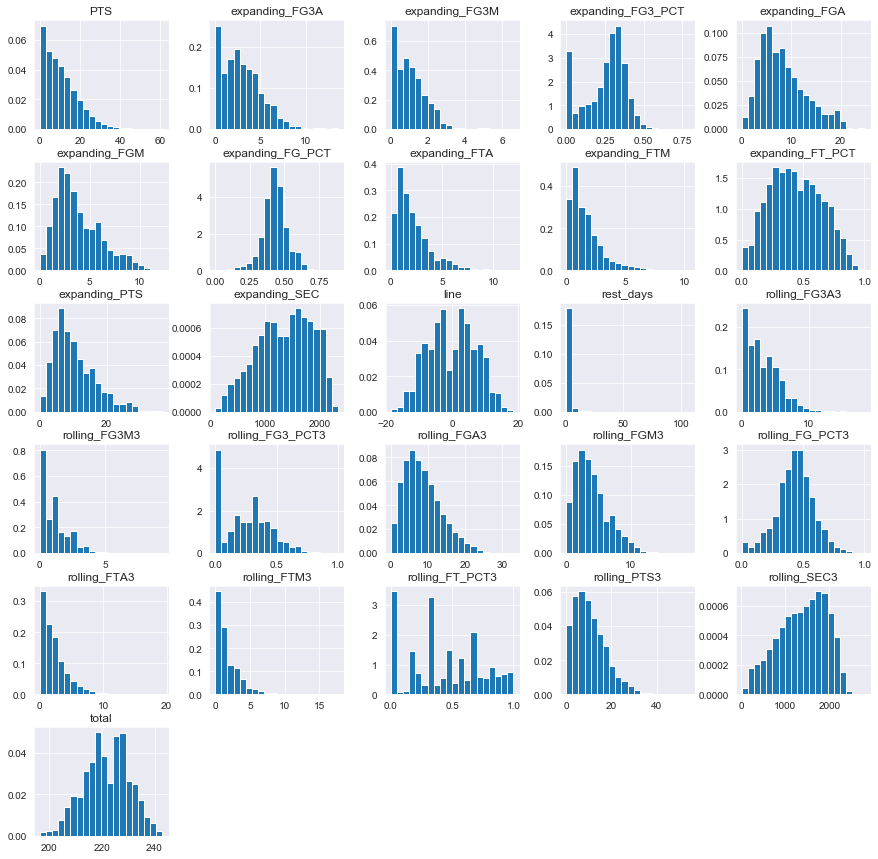

In [233]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
pre_test2.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);

In [234]:
pre_test2.columns

Index(['PTS', 'expanding_SEC', 'rolling_SEC3', 'expanding_FGM', 'rolling_FGM3',
       'expanding_FGA', 'rolling_FGA3', 'expanding_FG_PCT', 'rolling_FG_PCT3',
       'expanding_FG3M', 'rolling_FG3M3', 'expanding_FG3A', 'rolling_FG3A3',
       'expanding_FG3_PCT', 'rolling_FG3_PCT3', 'expanding_FTM',
       'rolling_FTM3', 'expanding_FTA', 'rolling_FTA3', 'expanding_FT_PCT',
       'rolling_FT_PCT3', 'expanding_PTS', 'rolling_PTS3', 'line', 'total',
       'site', 'date', 'rest_days'],
      dtype='object')

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.441     
Dependent Variable: PTS              AIC:                37704.3678
Date:               2020-01-16 11:37 BIC:                37766.1545
No. Observations:   16703            Log-Likelihood:     -18844.   
Df Model:           7                F-statistic:        1881.     
Df Residuals:       16695            Prob (F-statistic): 0.00      
R-squared:          0.441            Scale:              0.55933   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.9870   0.1473 -6.6988 0.0000 -1.2759 -0.6982
expanding_SEC        0.1970   0.0144 13.7127 0.0000  0.1689  0.2252
rolling_SEC3         0.2183   0.0132 16.5785 0.0000  0.1925  0.2441
expanding_FG_PCT     0.1627   0.0689  2.3625 0.0182  0.0277  0.297

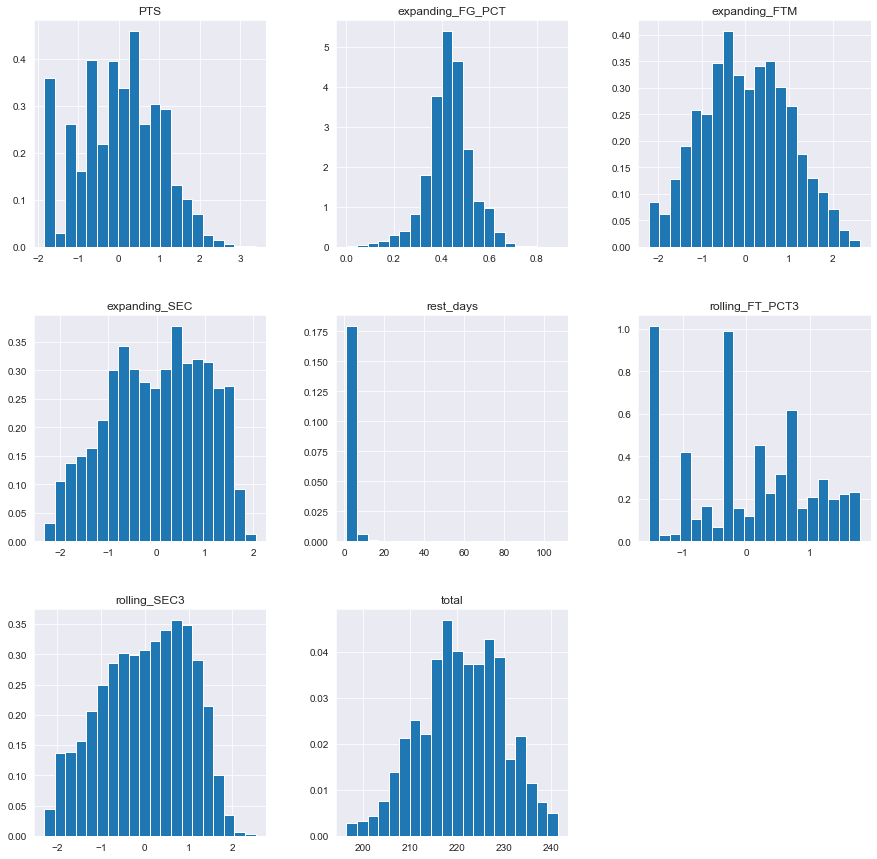

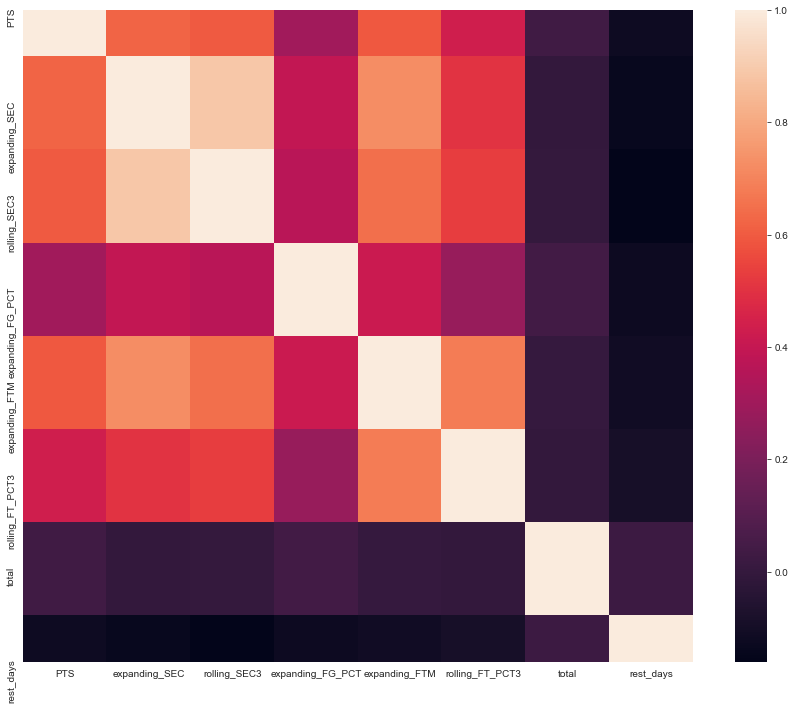

In [259]:
use_cols = ['PTS', 'expanding_SEC', 'rolling_SEC3',  'expanding_FG_PCT',  'expanding_FTM',
       'rolling_FT_PCT3', 'total',
        'date', 'rest_days']
transform = ['PTS', 'expanding_SEC', 'rolling_SEC3',
       'expanding_FTM','rolling_FT_PCT3']
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.449     
Dependent Variable: PTS              AIC:                37449.6788
Date:               2020-01-16 11:04 BIC:                37573.2523
No. Observations:   16703            Log-Likelihood:     -18709.   
Df Model:           15               F-statistic:        909.9     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.450            Scale:              0.55060   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.6793   0.1542 -4.4046 0.0000 -0.9816 -0.3770
site[T.home]         0.0217   0.0125  1.7350 0.0828 -0.0028  0.0462
rolling_SEC3         0.1391   0.0118 11.7712 0.0000  0.1160  0.1623
rolling_FGM3         0.3825   0.0657  5.8202 0.0000  0.2537  0.511

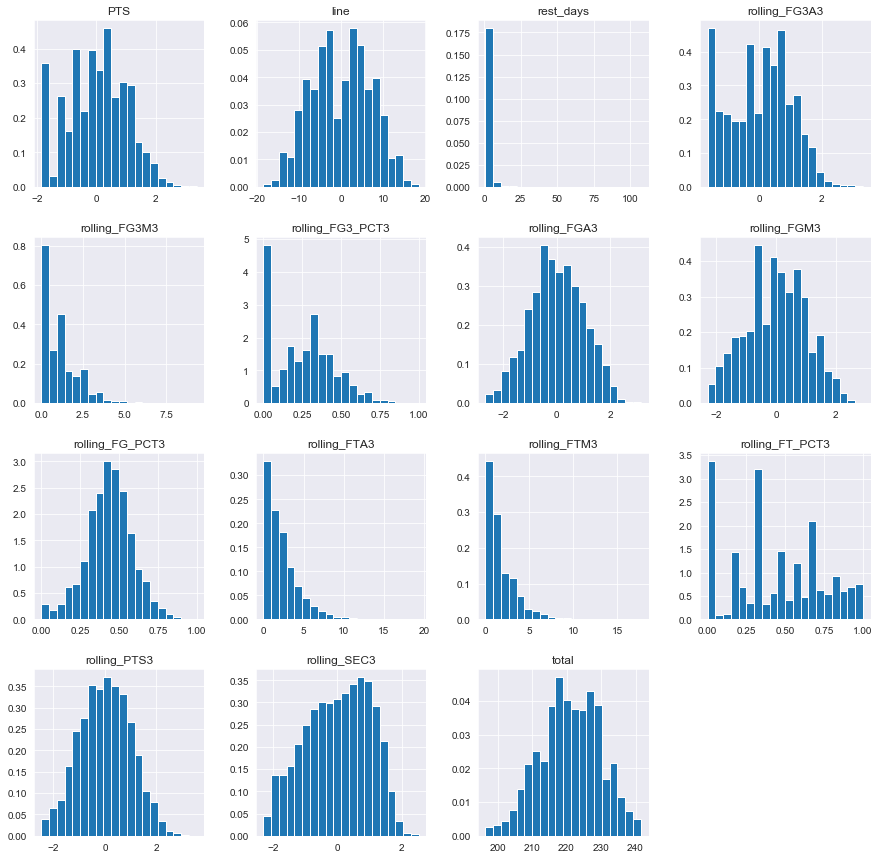

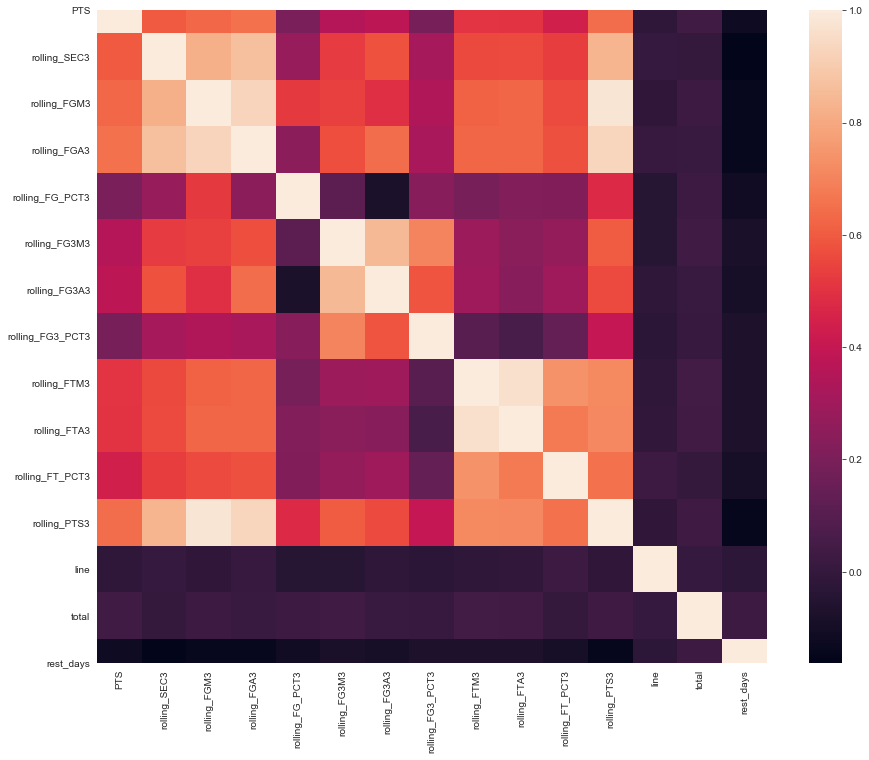

In [247]:
use_cols = ['PTS', 'rolling_SEC3','rolling_FGM3', 'rolling_FGA3', 'rolling_FG_PCT3',
           'rolling_FG3M3','rolling_FG3A3','rolling_FG3_PCT3','rolling_FTM3','rolling_FTA3',
           'rolling_FT_PCT3', 'rolling_PTS3', 'line', 'total',
           'site', 'date', 'rest_days']
transform = ['PTS', 'rolling_SEC3','rolling_FGM3', 'rolling_FGA3', 
           'rolling_FG3A3', 'rolling_PTS3']
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.361     
Dependent Variable: PTS              AIC:                39915.3227
Date:               2020-01-16 11:08 BIC:                39953.9394
No. Observations:   16703            Log-Likelihood:     -19953.   
Df Model:           4                F-statistic:        2364.     
Df Residuals:       16698            Prob (F-statistic): 0.00      
R-squared:          0.362            Scale:              0.63861   
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       -0.9601    0.1555  -6.1739  0.0000  -1.2650  -0.6553
rolling_SEC3     0.5956    0.0063  95.0573  0.0000   0.5833   0.6079
line            -0.0032    0.0009  -3.6659  0.0002  -0.0049  -0.0015
total            0.0044    0.0007   6.2975  0.0000   0.0031 

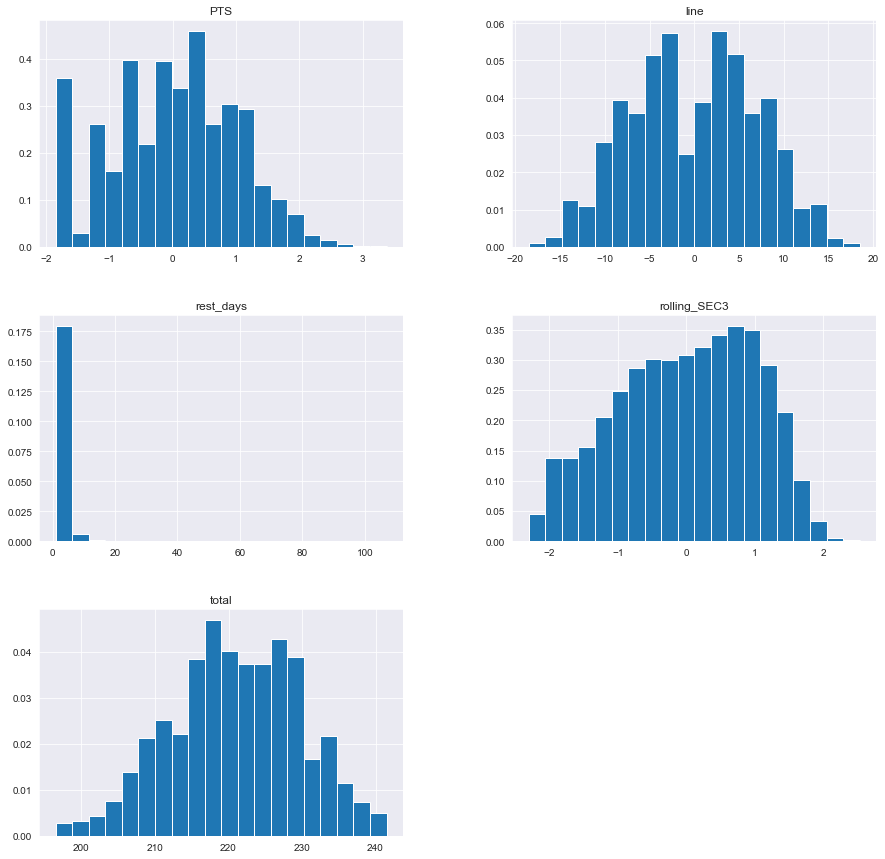

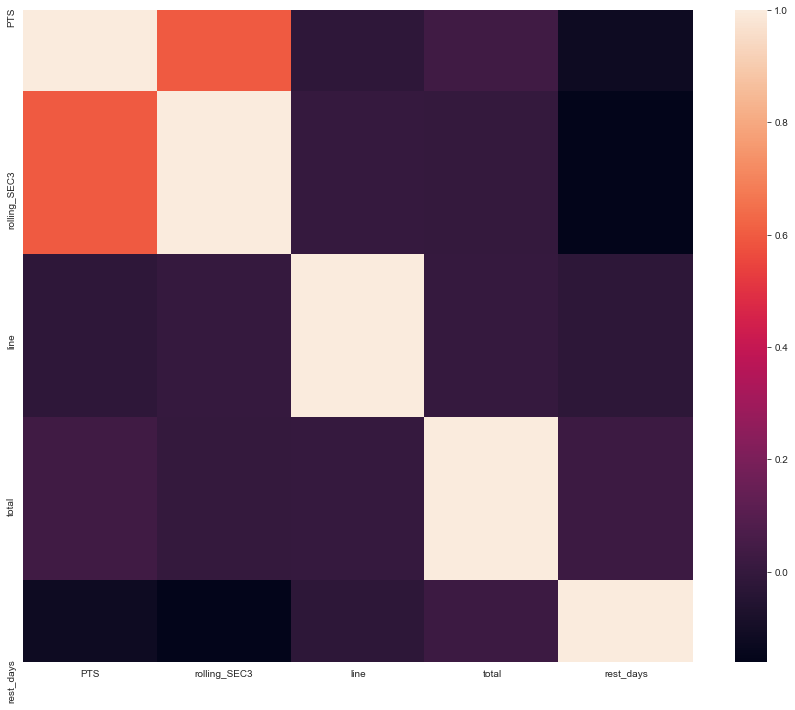

In [250]:
use_cols = ['PTS', 'rolling_SEC3', 'line', 'total',
            'date', 'rest_days']
transform = ['PTS', 'rolling_SEC3']
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.416     
Dependent Variable: PTS              AIC:                38434.3268
Date:               2020-01-16 11:08 BIC:                38472.9435
No. Observations:   16703            Log-Likelihood:     -19212.   
Df Model:           4                F-statistic:        2971.     
Df Residuals:       16698            Prob (F-statistic): 0.00      
R-squared:          0.416            Scale:              0.58442   
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      -0.4507    0.1488   -3.0280  0.0025  -0.7424  -0.1589
rolling_PTS3    0.6395    0.0060  106.8730  0.0000   0.6278   0.6512
line           -0.0019    0.0008   -2.2601  0.0238  -0.0035  -0.0003
total           0.0021    0.0007    3.1664  0.0015   0.0008 

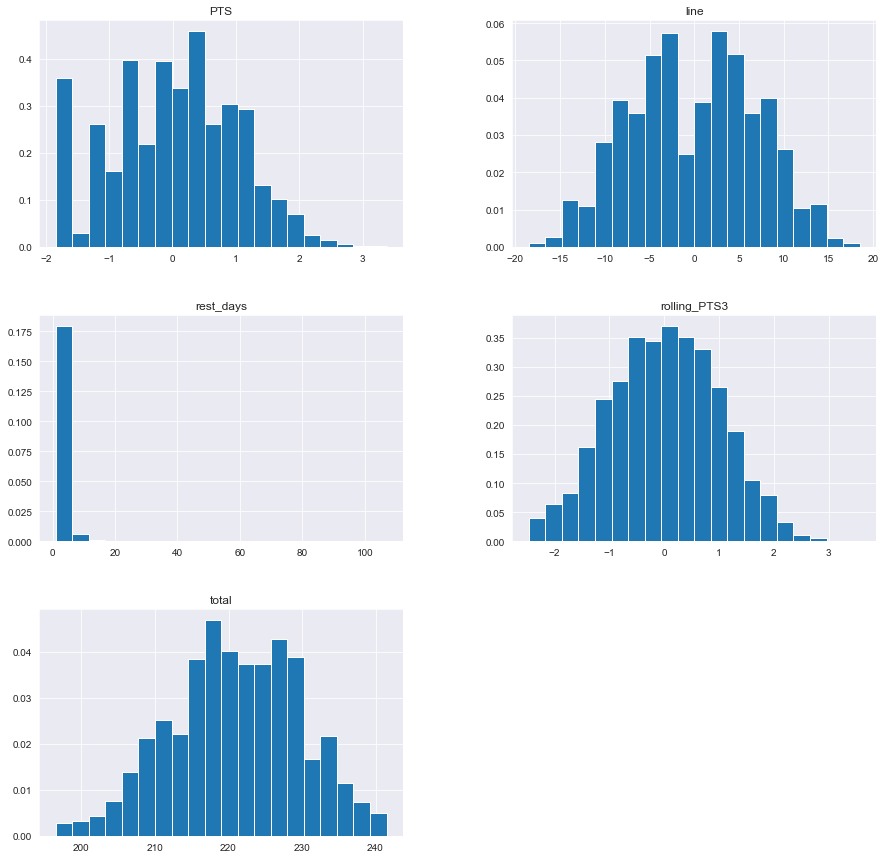

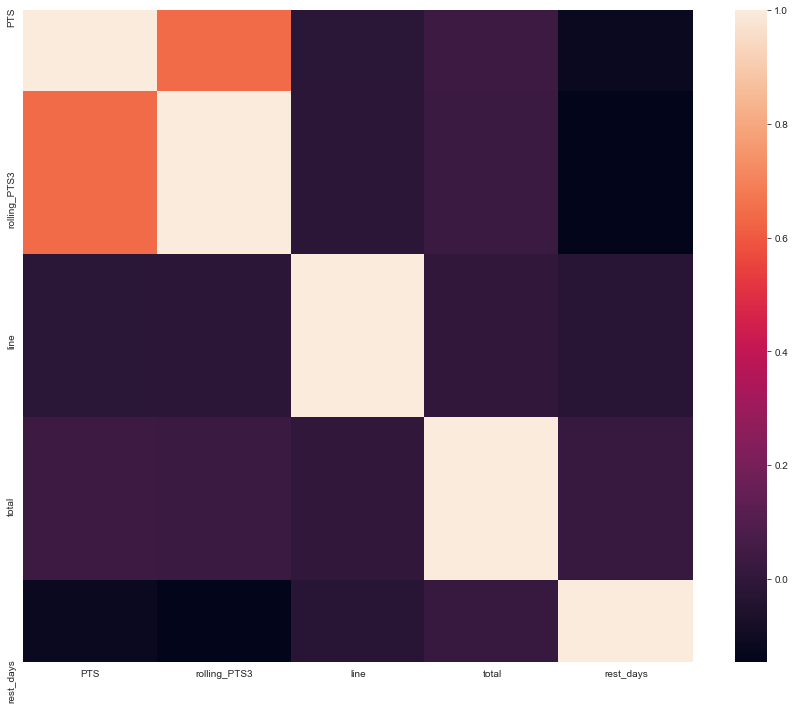

In [251]:
use_cols = ['PTS', 'rolling_PTS3', 'line', 'total',
            'date', 'rest_days']
transform = ['PTS', 'rolling_PTS3']
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.426     
Dependent Variable: PTS              AIC:                38128.8519
Date:               2020-01-16 11:10 BIC:                38167.4686
No. Observations:   16703            Log-Likelihood:     -19059.   
Df Model:           4                F-statistic:        3102.     
Df Residuals:       16698            Prob (F-statistic): 0.00      
R-squared:          0.426            Scale:              0.57383   
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      -0.7319    0.1474   -4.9649  0.0000  -1.0209  -0.4430
rolling_FGA3    0.6469    0.0059  109.2742  0.0000   0.6353   0.6585
line           -0.0040    0.0008   -4.7588  0.0000  -0.0056  -0.0023
total           0.0034    0.0007    5.1256  0.0000   0.0021 

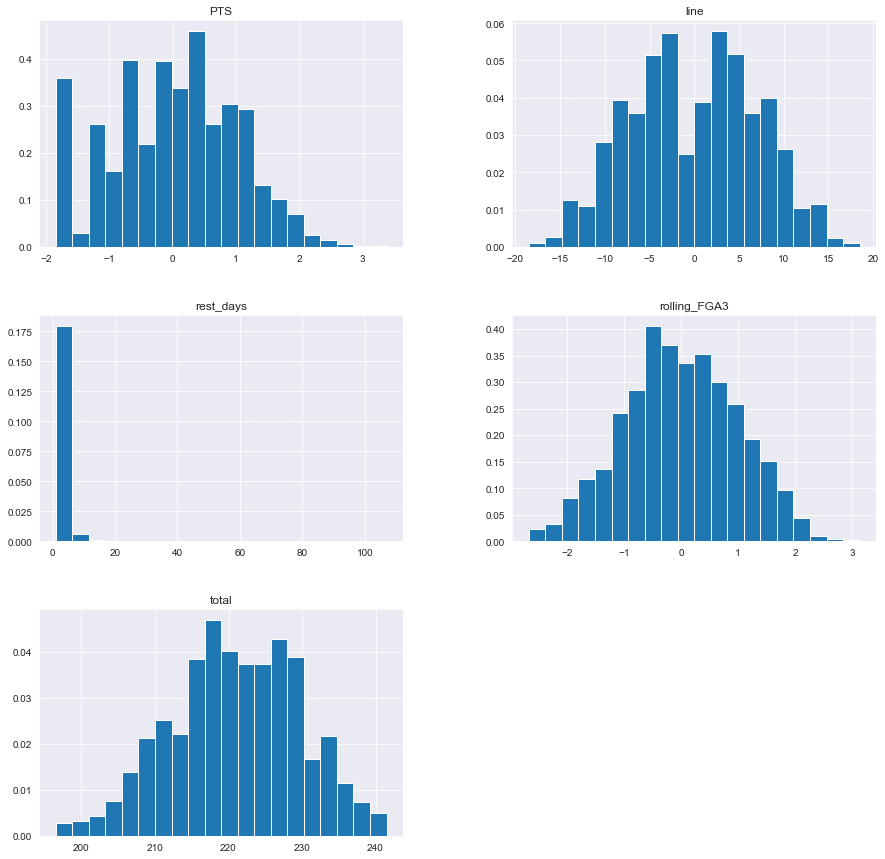

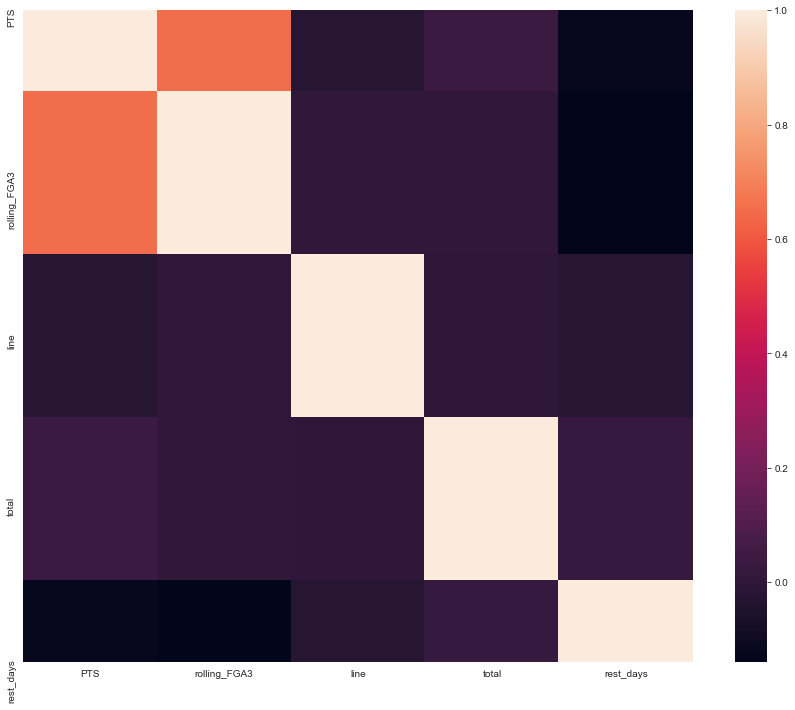

In [252]:
use_cols = ['PTS', 'rolling_FGA3', 'line', 'total',
            'date', 'rest_days']
transform = ['PTS', 'rolling_FGA3']
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.428     
Dependent Variable: PTS              AIC:                38090.1193
Date:               2020-01-16 11:16 BIC:                38136.4594
No. Observations:   16703            Log-Likelihood:     -19039.   
Df Model:           5                F-statistic:        2496.     
Df Residuals:       16697            Prob (F-statistic): 0.00      
R-squared:          0.428            Scale:              0.57247   
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       -0.6897    0.1474  -4.6794  0.0000  -0.9786  -0.4008
rolling_FGA3     0.6800    0.0079  86.5279  0.0000   0.6646   0.6954
rolling_FG3A3   -0.0204    0.0032  -6.3849  0.0000  -0.0266  -0.0141
line            -0.0042    0.0008  -5.0592  0.0000  -0.0058 

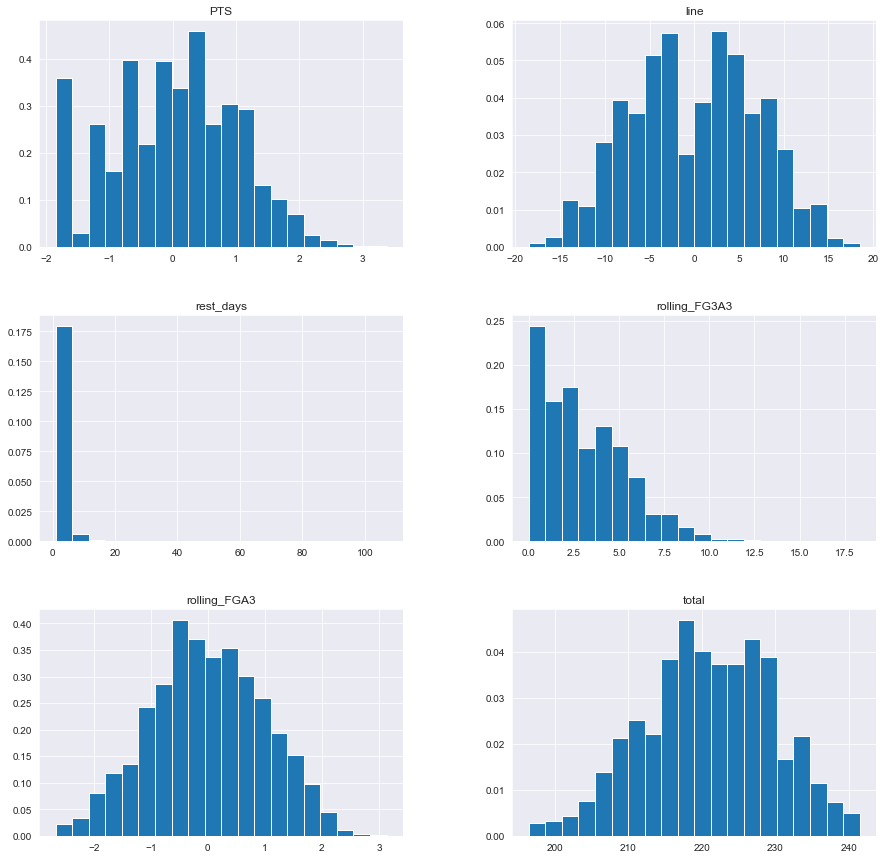

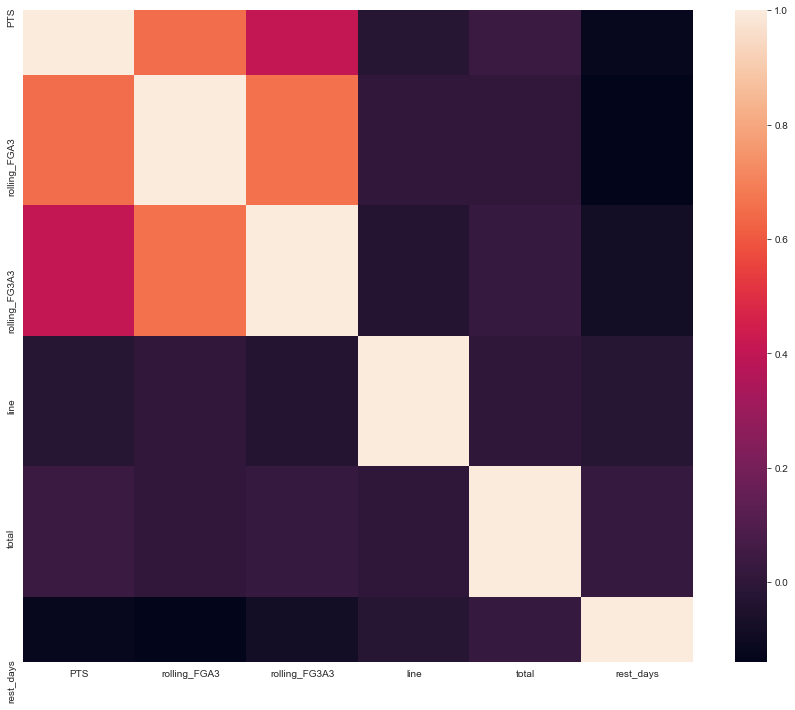

In [256]:
use_cols = ['PTS', 'rolling_FGA3', 'rolling_FG3A3','rolling_''line', 'total',
            'date', 'rest_days']
transform = ['PTS', 'rolling_FGA3', ]
do_regression_v2(pre_test2, use_cols=use_cols, vars_to_transform=transform)

## Trees

### First go with only expanding stats, no defense, no groups, no availability

In [15]:


train_dum = pd.get_dummies(train)

X = train_dum.drop(labels=['PTS', 'date'], axis=1)
y = train_dum['PTS']

regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X, y)

NameError: name 'train' is not defined

In [274]:
regr.score(X,y)

0.878612433104571

In [277]:
test_dum  = pd.get_dummies(test)
preds = regr.predict(test_dum.drop(labels=['PTS', 'date'], axis=1))
regr.score(test_dum.drop(labels=['PTS', 'date'], axis=1), test_dum['PTS'])

0.8774547657406725

In [276]:
sqrt(mean_squared_error(test_dum.PTS, preds))

2.8843207373002997

### Lagged 3 Games, without expanding, no defense, no groups, no availability

In [21]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
playerstats_2018_lag3 = formated_player_stats('box_score', cols = cols, year='2018', lag=3)
combined = join_set_columns(playerstats_2018_lag3, year='2018')
lagged3_raw = generate_pre_transformed(combined)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [22]:
all_cols = list(lagged3_raw.columns)
all_cols

['PTS',
 'expanding_SEC',
 'rolling_SEC3',
 'expanding_FGM',
 'rolling_FGM3',
 'expanding_FGA',
 'rolling_FGA3',
 'expanding_FG_PCT',
 'rolling_FG_PCT3',
 'expanding_FG3M',
 'rolling_FG3M3',
 'expanding_FG3A',
 'rolling_FG3A3',
 'expanding_FG3_PCT',
 'rolling_FG3_PCT3',
 'expanding_FTM',
 'rolling_FTM3',
 'expanding_FTA',
 'rolling_FTA3',
 'expanding_FT_PCT',
 'rolling_FT_PCT3',
 'expanding_PTS',
 'rolling_PTS3',
 'line',
 'total',
 'site',
 'date',
 'rest_days']

In [23]:
rolling_3_cols = [all_cols.pop(idx) if 'expanding' not in x else x for idx,x in enumerate(all_cols)]
rolling_3_cols

['PTS',
 'rolling_SEC3',
 'rolling_FGM3',
 'rolling_FGA3',
 'rolling_FG_PCT3',
 'rolling_FG3M3',
 'rolling_FG3A3',
 'rolling_FG3_PCT3',
 'rolling_FTM3',
 'rolling_FTA3',
 'rolling_FT_PCT3',
 'rolling_PTS3',
 'total',
 'date']

In [24]:
lagged3_clean = pd.get_dummies(lagged3_raw[rolling_3_cols].drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(lagged3_clean, 'PTS')

In [391]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [392]:
regr.score(X_train,y_train)

0.8713108545022962

In [393]:
preds = regr.predict(X_test)
regr.score(X_test, y_test)

0.8639913759462323

In [394]:
preds3 = regr.predict(X_test)
sqrt(mean_squared_error(y_test, preds3))

3.038216918332084

### Both 3 game lagged stats, expanding stats, no defense, no groups, no availability

In [322]:
lagged3_rol_exp = pd.get_dummies(lagged3_raw.drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(lagged3_rol_exp, 'PTS')

In [323]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [324]:
regr.score(X_train,y_train)

0.8870241257914787

In [326]:
preds_lag3_exp = regr.predict(X_test)
sqrt(mean_squared_error(y_test, preds_lag3_exp))

2.8229458419710487

### Lagged 5 Games, without expanding, no defense, no groups, no availability 

In [365]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
playerstats_2018_lag5 = formated_player_stats('box_score', cols = cols, year='2018', lag=5)
combined5 = join_set_columns(playerstats_2018_lag5, year='2018')
lagged5_raw = generate_pre_transformed(combined5)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [366]:
playerstats_2018_lag5

GAME_ID     TEAM_ID TEAM_ABBREVIATION     TEAM_CITY  PLAYER_ID  \
1895   0021800074  1610612738               BOS        Boston    1626179   
2525   0021800099  1610612738               BOS        Boston    1626179   
2926   0021800115  1610612738               BOS        Boston    1626179   
3230   0021800127  1610612738               BOS        Boston    1626179   
3685   0021800145  1610612738               BOS        Boston    1626179   
...           ...         ...               ...           ...        ...   
29658  0021801184  1610612745               HOU       Houston    1629185   
30038  0021801200  1610612745               HOU       Houston    1629185   
30638  0021801224  1610612755               PHI  Philadelphia    1629015   
30651  0021801224  1610612741               CHI       Chicago    1627215   
30530  0021801219  1610612747               LAL   Los Angeles    1629203   

          PLAYER_NAME START_POSITION COMMENT    MIN  FGM   FGA  FG_PCT  FG3M  \
1895     Terry Rozier                         27:21  4.0   8.0   0.500   2.0   
2525     Terry Rozier                         19:28  1.0   4.0   0.250   0.0   
2926     Terry Rozier                         26:09  3.0  11.0   0.273   1.0   
3230     Terry Rozier                         18:56  2.0   5.0   0.400   2.0   
3685     Terry Rozier                         22:21  2.0   9.0   0.222   2.0   
...               ...            ...     ...    ...  ...   ...     ...   ...   
29658   Chris Chiozza                          7:14  1.0   4.0   0.250   1.0   
30038   Chris Chiozza                          5:09  0.0   1.0   0.000   0.0   
30638    Zhaire Smith              G          31:53  7.0  13.0   0.538   2.0   
30651  Walt Lemon Jr.                         28:17  9.0  19.0   0.474   2.0   
30530  Jemerrio Jones              F          46:29  5.0  13.0   0.385   1.0   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB   REB  AST  STL  BLK   PF  \
1895    3.0    0.667  4.0  4.0     1.0   0.0   8.0   8.0  2.0  0.0  0.0  2.0   
2525    1.0    0.000  1.0  2.0     0.5   0.0   1.0   1.0  2.0  2.0  1.0  0.0   
2926    4.0    0.250  0.0  0.0     0.0   0.0   7.0   7.0  3.0  0.0  2.0  4.0   
3230    4.0    0.500  1.0  2.0     0.5   0.0   6.0   6.0  3.0  0.0  0.0  0.0   
3685    5.0    0.400  0.0  0.0     0.0   0.0   3.0   3.0  0.0  1.0  1.0  2.0   
...     ...      ...  ...  ...     ...   ...   ...   ...  ...  ...  ...  ...   
29658   3.0    0.333  0.0  0.0     0.0   0.0   0.0   0.0  1.0  0.0  0.0  1.0   
30038   1.0    0.000  0.0  0.0     0.0   0.0   1.0   1.0  1.0  0.0  1.0  0.0   
30638   5.0    0.400  1.0  2.0     0.5   2.0   2.0   4.0  5.0  0.0  0.0  0.0   
30651   2.0    1.000  0.0  0.0     0.0   2.0   4.0   6.0  4.0  0.0  0.0  2.0   
30530   2.0    0.500  0.0  0.0     0.0   6.0   9.0  15.0  3.0  2.0  2.0  2.0   

        PTS  PLUS_MINUS                 pk  TOS SEASON_ID  DK_PTS  DD  TD  \
1895   14.0        15.0  00218000741626179  0.0     22018   28.00   0   0   
2525    3.0         5.0  00218000991626179  1.0     22018   12.75   0   0   
2926    7.0       -12.0  00218001151626179  1.0     22018   24.25   0   0   
3230    7.0        -9.0  00218001271626179  1.0     22018   19.50   0   0   
3685    6.0       -13.0  00218001451626179  1.0     22018   14.25   0   0   
...     ...         ...                ...  ...       ...     ...  ..  ..   
29658   3.0        -9.0  00218011841629185  0.0     22018    5.00   0   0   
30038   0.0         1.0  00218012001629185  0.0     22018    4.75   0   0   
30638  17.0        15.0  00218012241629015  1.0     22018   30.00   0   0   
30651  20.0        -7.0  00218012241627215  2.0     22018   33.50   0   0   
30530  11.0        -3.0  00218012191629203  1.0     22018   43.75   1   0   

       doubles   SEC  game_number  expanding_SEC  rolling_SEC5  expanding_FGM  \
1895       1.0  1641          6.0    1356.400000        1356.4       3.000000   
2525       0.0  1168          7.0    1403.833333        1366.4       3.166667   
2926   

In [367]:
combined5

GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
7      0021800099  1610612738               BOS    Boston    1626179   
15     0021800115  1610612738               BOS    Boston    1626179   
23     0021800127  1610612738               BOS    Boston    1626179   
32     0021800145  1610612738               BOS    Boston    1626179   
42     0021800164  1610612738               BOS    Boston    1626179   
...           ...         ...               ...       ...        ...   
23077  0021800534  1610612757               POR  Portland    1627735   
23089  0021800540  1610612757               POR  Portland    1627735   
23226  0021800718  1610612757               POR  Portland    1627735   
23238  0021800734  1610612757               POR  Portland    1627735   
23248  0021800763  1610612757               POR  Portland    1627735   

           PLAYER_NAME START_POSITION COMMENT    MIN  FGM   FGA  FG_PCT  FG3M  \
7         Terry Rozier                         19:28  1.0   4.0   0.250   0.0   
15        Terry Rozier                         26:09  3.0  11.0   0.273   1.0   
23        Terry Rozier                         18:56  2.0   5.0   0.400   2.0   
32        Terry Rozier                         22:21  2.0   9.0   0.222   2.0   
42        Terry Rozier                         20:35  3.0   8.0   0.375   1.0   
...                ...            ...     ...    ...  ...   ...     ...   ...   
23077  Wade Baldwin IV                          1:49  0.0   0.0   0.000   0.0   
23089  Wade Baldwin IV                         10:14  1.0   4.0   0.250   0.0   
23226  Wade Baldwin IV                          6:38  0.0   1.0   0.000   0.0   
23238  Wade Baldwin IV                          8:25  0.0   2.0   0.000   0.0   
23248  Wade Baldwin IV                          6:40  2.0   4.0   0.500   0.0   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK   PF  \
7       1.0    0.000  1.0  2.0    0.50   0.0   1.0  1.0  2.0  2.0  1.0  0.0   
15      4.0    0.250  0.0  0.0    0.00   0.0   7.0  7.0  3.0  0.0  2.0  4.0   
23      4.0    0.500  1.0  2.0    0.50   0.0   6.0  6.0  3.0  0.0  0.0  0.0   
32      5.0    0.400  0.0  0.0    0.00   0.0   3.0  3.0  0.0  1.0  1.0  2.0   
42      3.0    0.333  3.0  4.0    0.75   2.0   4.0  6.0  1.0  0.0  0.0  1.0   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
23077   0.0    0.000  2.0  2.0    1.00   0.0   0.0  0.0  0.0  0.0  0.0  1.0   
23089   0.0    0.000  3.0  4.0    0.75   0.0   1.0  1.0  2.0  0.0  0.0  1.0   
23226   0.0    0.000  0.0  0.0    0.00   0.0   1.0  1.0  0.0  0.0  0.0  1.0   
23238   2.0    0.000  0.0  0.0    0.00   0.0   3.0  3.0  2.0  1.0  0.0  3.0   
23248   0.0    0.000  0.0  0.0    0.00   1.0   1.0  2.0  0.0  0.0  0.0  0.0   

        PTS  PLUS_MINUS                 pk  TOS SEASON_ID  DK_PTS  DD  TD  \
7       3.0         5.0  00218000991626179  1.0     22018   12.75   0   0   
15      7.0       -12.0  00218001151626179  1.0     22018   24.25   0   0   
23      7.0        -9.0  00218001271626179  1.0     22018   19.50   0   0   
32      6.0       -13.0  00218001451626179  1.0     22018   14.25   0   0   
42     10.0        -6.0  00218001641626179  1.0     22018   19.00   0   0   
...     ...         ...                ...  ...       ...     ...  ..  ..   
23077   2.0         2.0  00218005341627735  0.0     22018    2.00   0   0   
23089   5.0        -7.0  00218005401627735  2.0     22018    8.25   0   0   
23226   0.0        -8.0  00218007181627735  0.0     22018    1.25   0   0   
23238   0.0        -7.0  00218007341627735  2.0     22018    7.75   0   0   
23248   4.0         1.0  00218007631627735  1.0     22018    6.00   0   0   

       doubles   SEC  game_number  expanding_SEC  rolling_SEC5  expanding_FGM  \
7          0.0  1168          7.0    1403.833333        1366.4       3.166667   
15         0.0  1569          8.0    1370.142857        1321.4       2.857143   
23         0.0  1136          9.0    1395.000000       

In [368]:
lagged5_raw

PTS  expanding_SEC  rolling_SEC5  expanding_FGM  rolling_FGM5  \
4933  37.0    2008.000000        1945.8      10.666667           9.8   
4934   6.0    1247.166667        1236.6       3.666667           3.8   
4935  12.0    1491.666667        1540.4       3.833333           3.8   
4938   7.0    1474.833333        1459.6       3.000000           3.2   
4937   2.0    2076.000000        2109.4       4.000000           4.4   
...    ...            ...           ...            ...           ...   
2208   8.0    1366.731343        1939.4       2.701493           5.4   
2207  18.0     797.440000        1195.4       2.413333           5.4   
1228  20.0    1128.781818         741.4       2.272727           1.8   
4161  15.0    2160.847222        2218.8       8.652778           8.8   
2209   6.0     473.857143         519.8       1.071429           1.6   

      expanding_FGA  rolling_FGA5  expanding_FG_PCT  rolling_FG_PCT5  \
4933      21.666667          20.2          0.489500           0.4840   
4934       6.500000           6.6          0.572333           0.5868   
4935      10.000000           9.8          0.387500           0.3922   
4938       8.000000           8.2          0.369000           0.3856   
4937       9.333333           9.6          0.466667           0.5100   
...             ...           ...               ...              ...   
2208       6.477612           9.8          0.399896           0.5452   
2207       4.760000           9.6          0.500267           0.5678   
1228       6.109091           3.4          0.376600           0.5112   
4161      20.319444          21.0          0.422903           0.4176   
2209       2.357143           3.2          0.350786           0.2250   

      expanding_FG3M  rolling_FG3M5  expanding_FG3A  rolling_FG3A5  \
4933        4.833333            4.4       10.666667           10.2   
4934        0.333333            0.4        0.666667            0.8   
4935        1.500000            1.4        3.833333            3.8   
4938        1.000000            1.0        4.500000            4.2   
4937        2.000000            2.2        5.166667            5.4   
...              ...            ...             ...            ...   
2208        0.597015            0.8        1.850746            2.2   
2207        0.226667            0.4        0.693333            0.8   
1228        0.454545            0.6        1.781818            1.0   
4161        1.638889            2.4        5.666667            7.4   
2209        0.214286            0.4        1.000000            1.4   

      expanding_FG3_PCT  rolling_FG3_PCT5  expanding_FTM  rolling_FTM5  \
4933           0.437333            0.4172       4.666667           4.8   
4934           0.166667            0.2000       1.666667           1.2   
4935           0.375000            0.3500       2.166667           2.6   
4938           0.177833            0.1800       0.500000           0.6   
4937           0.424833            0.4598       0.666667           0.8   
...                 ...               ...            ...           ...   
2208           0.228149            0.2500       0.865672           0.8   
2207           0.186667            0.4000       1.173333           3.0   
1228           0.199091            0.3334       1.290909           1.2   
4161           0.266375            0.3160       4.111111           4.0   
2209           0.130929            0.1666       0.000000           0.0   

      expanding_FTA  rolling_FTA5  expanding_FT_PCT  rolling_FT_PCT5  \
4933       5.500000           5.6          0.880000           0.8960   
4934       2.833333           2.2          0.375000           0.3166   
4935       2.333333           2.8          0.638833           0.7666   
4938       1.000000           0.8          0.250000           0.3000   
4937       0.833333           1.0          0.333333           0.4000   
...             ...           ...               ...              ...   
2208       1.029851           0.8          

In [395]:
all_cols5 = list(lagged5_raw.columns)
rolling_5_cols = [all_cols5.pop(idx) if 'expanding' not in x else x for idx,x in enumerate(all_cols5)]
lagged5_clean = pd.get_dummies(lagged5_raw[rolling_5_cols].drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(lagged5_clean, 'PTS')

In [396]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.8763185117914

In [397]:
preds_lag5 = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_lag5))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.8698152172539573
RMSE: 2.985581141578081


### Both 5 game lagged stats, expanding stats, no defense, no groups, no availability 

In [399]:
lagged5_rol_exp = pd.get_dummies(lagged5_raw.drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(lagged5_rol_exp, 'PTS')

In [400]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.8846030012605549

In [401]:
preds_lag5_exp = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_lag5_exp))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.8794038174471238
RMSE: 2.873528757412754


### 3 and 5 game lagged stats and expanding stats, no defesne, no groups, no availability

In [25]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
playerstats_2018_lag_3_and5 = formated_player_statsV2('box_score', cols = cols, year='2018', lag=[3,5])
combined_3_and_5 = join_set_columns(playerstats_2018_lag_3_and5, year='2018')
lagged_3_5_raw = generate_pre_transformed(combined_3_and_5)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [26]:
lagged_3_5_raw

PTS  expanding_SEC  rolling_SEC3  rolling_SEC5  expanding_FGM  \
4933  37.0    2008.000000   1907.000000        1945.8      10.666667   
4934   6.0    1247.166667   1035.000000        1236.6       3.666667   
4935  12.0    1491.666667   1503.666667        1540.4       3.833333   
4938   7.0    1474.833333   1420.000000        1459.6       3.000000   
4937   2.0    2076.000000   2081.333333        2109.4       4.000000   
...    ...            ...           ...           ...            ...   
2208   8.0    1366.731343   1889.000000        1939.4       2.701493   
2207  18.0     797.440000   1310.333333        1195.4       2.413333   
1228  20.0    1128.781818    862.333333         741.4       2.272727   
4161  15.0    2160.847222   2209.000000        2218.8       8.652778   
2209   6.0     473.857143    472.000000         519.8       1.071429   

      rolling_FGM3  rolling_FGM5  expanding_FGA  rolling_FGA3  rolling_FGA5  \
4933      9.000000           9.8      21.666667     18.000000          20.2   
4934      3.666667           3.8       6.500000      6.666667           6.6   
4935      4.333333           3.8      10.000000     10.000000           9.8   
4938      2.666667           3.2       8.000000      8.000000           8.2   
4937      4.666667           4.4       9.333333     10.000000           9.6   
...            ...           ...            ...           ...           ...   
2208      4.666667           5.4       6.477612      9.333333           9.8   
2207      5.666667           5.4       4.760000     10.666667           9.6   
1228      2.333333           1.8       6.109091      4.333333           3.4   
4161      9.000000           8.8      20.319444     21.000000          21.0   
2209      1.000000           1.6       2.357143      2.666667           3.2   

      expanding_FG_PCT  rolling_FG_PCT3  rolling_FG_PCT5  expanding_FG3M  \
4933          0.489500         0.489333           0.4840        4.833333   
4934          0.572333         0.569667           0.5868        0.333333   
4935          0.387500         0.447333           0.3922        1.500000   
4938          0.369000         0.333000           0.3856        1.000000   
4937          0.466667         0.533333           0.5100        2.000000   
...                ...              ...              ...             ...   
2208          0.399896         0.492000           0.5452        0.597015   
2207          0.500267         0.529667           0.5678        0.226667   
1228          0.376600         0.407667           0.5112        0.454545   
4161          0.422903         0.422000           0.4176        1.638889   
2209          0.350786         0.166667           0.2250        0.214286   

      rolling_FG3M3  rolling_FG3M5  expanding_FG3A  rolling_FG3A3  \
4933       3.333333            4.4       10.666667       8.666667   
4934       0.666667            0.4        0.666667       0.666667   
4935       1.666667            1.4        3.833333       3.666667   
4938       0.333333            1.0        4.500000       3.333333   
4937       2.000000            2.2        5.166667       5.333333   
...             ...            ...             ...            ...   
2208       0.333333            0.8        1.850746       2.333333   
2207       0.333333            0.4        0.693333       1.000000   
1228       0.666667            0.6        1.781818       1.000000   
4161       2.333333            2.4        5.666667       6.666667   
2209       0.333333            0.4        1.000000       1.333333   

      rolling_FG3A5  expanding_FG3_PCT  rolling_FG3_PCT3  rolling_FG3_PCT5  \
4933           10.2           0.437333          0.373000            0.4172   
4934            0.8           0.166667          0.333333            0.2000   
4935            3.8           0.375000          0.472333            0.3500   
4938            4.2           0.177833          0.055667            0.1800   
4937            5.4           0.424833          0.421000     

In [27]:
lagged_3_5_rol_exp = pd.get_dummies(lagged_3_5_raw.drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(lagged_3_5_rol_exp, 'PTS')

In [415]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.888432703969877

In [417]:
preds_lag_3_5_exp = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_lag_3_5_exp))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.8825011690305765
RMSE: 2.836387353757287


In [421]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.01810855266028527
rolling_SEC3: 0.021021953448655786
rolling_SEC5: 0.018793368021130397
expanding_FGM: 0.15782557588876295
rolling_FGM3: 0.007889656714177632
rolling_FGM5: 0.00863300643645394
expanding_FGA: 0.019940141217585573
rolling_FGA3: 0.013663867095405176
rolling_FGA5: 0.031334284851072675
expanding_FG_PCT: 0.017098491071121907
rolling_FG_PCT3: 0.016925573801345017
rolling_FG_PCT5: 0.016102188922546796
expanding_FG3M: 0.011467752347485856
rolling_FG3M3: 0.004698909321923961
rolling_FG3M5: 0.004847858809399255
expanding_FG3A: 0.0120344710407081
rolling_FG3A3: 0.007612172657232245
rolling_FG3A5: 0.009203842149434864
expanding_FG3_PCT: 0.014137317214038304
rolling_FG3_PCT3: 0.011314719073391422
rolling_FG3_PCT5: 0.012567519319501728
expanding_FTM: 0.015196820284951899
rolling_FTM3: 0.006203454518991313
rolling_FTM5: 0.006938543629584152
expanding_FTA: 0.013891405488073513
rolling_FTA3: 0.007372241636439101
rolling_FTA5: 0.007906936952638255
expanding_FT_PCT: 0.0169

### All time demensions, with defense

In [23]:
all_with_d = join_set_columns_v2(playerstats_2018_lag_3_and5, year='2018')
all_with_d_raw = generate_pre_transformed(all_with_d)

In [24]:
all_with_d_clean = pd.get_dummies(all_with_d_raw.drop('date', axis=1))
X_train, y_train, X_test, y_test = train_test(all_with_d_clean, 'PTS')

In [444]:
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.9143906074994428

In [445]:
preds_d = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_d))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.9093661662139862
RMSE: 2.4911159532096914


In [446]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.017706606803732265
rolling_SEC3: 0.02055952590635266
rolling_SEC5: 0.018617038227223662
expanding_FGM: 0.1521594738393591
rolling_FGM3: 0.00779145308261003
rolling_FGM5: 0.008524319337793051
expanding_FGA: 0.01964912083270759
rolling_FGA3: 0.01344810729303653
rolling_FGA5: 0.03234145242121184
expanding_FG_PCT: 0.016948213400609806
rolling_FG_PCT3: 0.016792733426101457
rolling_FG_PCT5: 0.01602689403609441
expanding_FG3M: 0.011365899882443617
rolling_FG3M3: 0.004652679190164746
rolling_FG3M5: 0.004827528378743134
expanding_FG3A: 0.011856659601706176
rolling_FG3A3: 0.007995566084287696
rolling_FG3A5: 0.00887228162064143
expanding_FG3_PCT: 0.013809716278211395
rolling_FG3_PCT3: 0.011030440223089369
rolling_FG3_PCT5: 0.012056658831869212
expanding_FTM: 0.014982166792063586
rolling_FTM3: 0.00611540334571121
rolling_FTM5: 0.006748337484750407
expanding_FTA: 0.014117188450973645
rolling_FTA3: 0.007616513564042736
rolling_FTA5: 0.007865088668289704
expanding_FT_PCT: 0.016346403

### Add in player groups from clustering

In [28]:
cluster_1 = pd.read_csv('cluster_group_1.csv', usecols=['name', 'cluster'])
cluster_2 = pd.read_csv('cluster_group_2.csv', usecols=['name', 'cluster'])
cluster_3 = pd.read_csv('cluster_group_3.csv', usecols=['name', 'cluster'])

In [26]:
cluster_1.columns

Index(['name', 'cluster'], dtype='object')

In [27]:
len(cluster_1['cluster'].unique())

25

In [28]:
merged_cluster1 = playerstats_2018_lag_3_and5.merge(cluster_1, how='left',left_on='PLAYER_NAME', right_on='name')
merged_dropped = merged_cluster1.drop('name', axis=1)
merged_dropped['cluster'] = merged_dropped['cluster'].fillna(len(cluster_1['cluster'].unique()))

In [29]:
merged_dropped[merged_dropped['PLAYER_NAME']== 'Kemba Walker']

GAME_ID     TEAM_ID TEAM_ABBREVIATION  TEAM_CITY  PLAYER_ID  \
2866  0021800067  1610612766               CHA  Charlotte     202689   
2867  0021800078  1610612766               CHA  Charlotte     202689   
2868  0021800096  1610612766               CHA  Charlotte     202689   
2869  0021800111  1610612766               CHA  Charlotte     202689   
2870  0021800126  1610612766               CHA  Charlotte     202689   
...          ...         ...               ...        ...        ...   
2938  0021801171  1610612766               CHA  Charlotte     202689   
2939  0021801180  1610612766               CHA  Charlotte     202689   
2940  0021801198  1610612766               CHA  Charlotte     202689   
2941  0021801209  1610612766               CHA  Charlotte     202689   
2942  0021801222  1610612766               CHA  Charlotte     202689   

       PLAYER_NAME START_POSITION COMMENT    MIN   FGM   FGA  FG_PCT  FG3M  \
2866  Kemba Walker              G          26:13  11.0  18.0   0.611   5.0   
2867  Kemba Walker              G          34:55  11.0  31.0   0.355   3.0   
2868  Kemba Walker              G          35:17   6.0  14.0   0.429   4.0   
2869  Kemba Walker              G          31:10   7.0  16.0   0.438   2.0   
2870  Kemba Walker              G          29:56   6.0  12.0   0.500   4.0   
...            ...            ...     ...    ...   ...   ...     ...   ...   
2938  Kemba Walker              G          35:29   9.0  17.0   0.529   2.0   
2939  Kemba Walker              G          35:48  11.0  18.0   0.611   4.0   
2940  Kemba Walker              G          40:54  11.0  29.0   0.379   3.0   
2941  Kemba Walker              G          27:21   9.0  18.0   0.500   4.0   
2942  Kemba Walker              G          40:09  16.0  25.0   0.640   4.0   

      FG3A  FG3_PCT   FTM   FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK   PF  \
2866  10.0    0.500   3.0   3.0   1.000   1.0   5.0  6.0  7.0  0.0  0.0  3.0   
2867  15.0    0.200  12.0  14.0   0.857   1.0   5.0  6.0  6.0  1.0  2.0  1.0   
2868   8.0    0.500   3.0   4.0   0.750   0.0   4.0  4.0  8.0  0.0  0.0  0.0   
2869   8.0    0.250   5.0   5.0   1.000   1.0   4.0  5.0  6.0  1.0  0.0  3.0   
2870   9.0    0.444   2.0   2.0   1.000   1.0   4.0  5.0  5.0  0.0  0.0  1.0   
...    ...      ...   ...   ...     ...   ...   ...  ...  ...  ...  ...  ...   
2938   5.0    0.400  12.0  13.0   0.923   0.0   3.0  3.0  7.0  2.0  0.0  0.0   
2939   8.0    0.500   3.0   3.0   1.000   0.0   6.0  6.0  8.0  0.0  0.0  1.0   
2940  11.0    0.273   6.0   7.0   0.857   1.0   7.0  8.0  7.0  1.0  0.0  2.0   
2941  10.0    0.400   1.0   2.0   0.500   0.0   3.0  3.0  7.0  0.0  0.0  2.0   
2942   9.0    0.444   7.0   7.0   1.000   0.0   2.0  2.0  5.0  0.0  2.0  1.0   

       PTS  PLUS_MINUS                pk  TOS SEASON_ID  DK_PTS  DD  TD  \
2866  30.0        20.0  0021800067202689  2.0     22018   49.50   0   0   
2867  37.0         6.0  0021800078202689  2.0     22018   60.00   0   0   
2868  19.0         1.0  0021800096202689  1.0     22018   37.50   0   0   
2869  21.0         2.0  0021800111202689  2.0     22018   38.25   0   0   
2870  18.0        20.0  0021800126202689  3.0     22018   32.25   0   0   
...    ...         ...               ...  ...       ...     ...  ..  ..   
2938  32.0         3.0  0021801171202689  4.0     22018   49.25   0   0   
2939  29.0         0.0  0021801180202689  0.0     22018   50.50   0   0   
2940  31.0        16.0  0021801198202689  1.0     22018   54.50   0   0   
2941  23.0         9.0  0021801209202689  2.0     22018   38.25   0   0   
2942  43.0         0.0  0021801222202689  2.0     22018   58.00   0   0   

      doubles   SEC  game_number  expanding_SEC  rolling_SEC3  rolling_SEC5  \
2866      1.0  1573          6.0    2095.000000   2183.333333        2095.0   
2867      1.0  2095          7.0    2008.000000   1907.000000        1945.8   
2868      1.0  2117          8.0    2020.428571   1934.000000        2043.6   
2869      1.0  1870          

In [29]:
def merge_with_cluster(lagged_calc_df, cluster_df):
    
    cluster_df['cluster'] = cluster_df['cluster'].astype('str')
    
    unmarked_cluster = len(cluster_df['cluster'].unique())
    
    merged_cluster = lagged_calc_df.merge(cluster_df, how='left',left_on='PLAYER_NAME', right_on='name')
    merged_dropped = merged_cluster.drop('name', axis=1)
    
    merged_dropped['cluster'] = merged_dropped['cluster'].fillna(unmarked_cluster)
    
    return merged_dropped
    

#### Cluster 1

In [32]:
all_cluster1 = merge_with_cluster(playerstats_2018_lag_3_and5, cluster_1)
all_d_cluster1 = join_set_columns_v2(all_cluster1, year='2018')
all_d_cluster1_raw = generate_pre_transformed(all_d_cluster1)
all_with_dummies = pd.get_dummies(all_d_cluster1_raw.drop('date', axis=1))
all_with_interaction_clean = create_interaction(all_with_dummies, 'oteam', 'cluster')

In [110]:
X_train, y_train, X_test, y_test = train_test(all_with_interaction_clean, 'PTS')
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.915449560024379

In [111]:
preds_cluster1 = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_cluster1))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.9106910780819797
RMSE: 2.4728409896526715


In [112]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.01575096402563621
rolling_SEC3: 0.018740976861476123
rolling_SEC5: 0.017016018615779373
expanding_FGM: 0.15051436285104172
rolling_FGM3: 0.006899492953852627
rolling_FGM5: 0.007662606193794607
expanding_FGA: 0.017676393778148017
rolling_FGA3: 0.012379323210339268
rolling_FGA5: 0.03090406998745681
expanding_FG_PCT: 0.014777157653156289
rolling_FG_PCT3: 0.015261295101872656
rolling_FG_PCT5: 0.014220312235670303
expanding_FG3M: 0.009894356189338148
rolling_FG3M3: 0.004036965362155528
rolling_FG3M5: 0.004391884884646006
expanding_FG3A: 0.010265891512025947
rolling_FG3A3: 0.0069744282051334375
rolling_FG3A5: 0.007970819512432536
expanding_FG3_PCT: 0.011808694969689126
rolling_FG3_PCT3: 0.009845780596679865
rolling_FG3_PCT5: 0.0108174517771201
expanding_FTM: 0.013428359483219025
rolling_FTM3: 0.005527338156269434
rolling_FTM5: 0.0061071650426813345
expanding_FTA: 0.01271344032637024
rolling_FTA3: 0.006527503440112654
rolling_FTA5: 0.007035251038644414
expanding_FT_PCT: 0.014

interaction_oteam_CHA_cluster_22: 6.699024266842827e-05
interaction_oteam_CHA_cluster_23: 1.842889224829924e-05
interaction_oteam_CHA_cluster_24: 4.807552595018592e-06
interaction_oteam_CHA_cluster_3: 0.00021078080757384372
interaction_oteam_CHA_cluster_4: 0.00010986286238606328
interaction_oteam_CHA_cluster_5: 3.649628169181487e-05
interaction_oteam_CHA_cluster_6: 3.7293419715206452e-06
interaction_oteam_CHA_cluster_7: 1.3415191082229115e-05
interaction_oteam_CHA_cluster_8: 3.889906166978194e-06
interaction_oteam_CHA_cluster_9: 0.00022716056965963325
interaction_oteam_CHI_cluster_25: 0.00026186160139426626
interaction_oteam_CHI_cluster_0: 2.3027829832116798e-05
interaction_oteam_CHI_cluster_1: 0.0002776972051086582
interaction_oteam_CHI_cluster_10: 1.2524538997249921e-05
interaction_oteam_CHI_cluster_11: 0.00010768448928926567
interaction_oteam_CHI_cluster_12: 2.0617635935259953e-05
interaction_oteam_CHI_cluster_13: 0.0
interaction_oteam_CHI_cluster_14: 1.1290982092952479e-05
interact

interaction_oteam_GSW_cluster_2: 0.0
interaction_oteam_GSW_cluster_20: 3.382524913226248e-05
interaction_oteam_GSW_cluster_21: 1.4334585257296538e-06
interaction_oteam_GSW_cluster_22: 8.998618421316815e-06
interaction_oteam_GSW_cluster_23: 0.0001696739934941881
interaction_oteam_GSW_cluster_24: 3.326838172878855e-05
interaction_oteam_GSW_cluster_3: 4.943525821096037e-05
interaction_oteam_GSW_cluster_4: 5.540646628504213e-06
interaction_oteam_GSW_cluster_5: 0.00045895289438876774
interaction_oteam_GSW_cluster_6: 3.013047375644334e-05
interaction_oteam_GSW_cluster_7: 0.00015844010913690427
interaction_oteam_GSW_cluster_8: 2.50222309652766e-05
interaction_oteam_GSW_cluster_9: 4.8958461611508805e-05
interaction_oteam_HOU_cluster_25: 0.000682935934483428
interaction_oteam_HOU_cluster_0: 1.0464133490673009e-05
interaction_oteam_HOU_cluster_1: 0.00018142519731358561
interaction_oteam_HOU_cluster_10: 4.5458494083886595e-05
interaction_oteam_HOU_cluster_11: 0.00017352520516894385
interaction_ot

interaction_oteam_MIA_cluster_19: 0.0
interaction_oteam_MIA_cluster_2: 0.0
interaction_oteam_MIA_cluster_20: 8.291380703320488e-05
interaction_oteam_MIA_cluster_21: 8.850728444804589e-05
interaction_oteam_MIA_cluster_22: 9.574212338214535e-06
interaction_oteam_MIA_cluster_23: 0.00014262137624046899
interaction_oteam_MIA_cluster_24: 0.00012427000919262084
interaction_oteam_MIA_cluster_3: 0.00011157927289199295
interaction_oteam_MIA_cluster_4: 2.435333088685239e-05
interaction_oteam_MIA_cluster_5: 1.4355033370332292e-05
interaction_oteam_MIA_cluster_6: 9.265508886853863e-06
interaction_oteam_MIA_cluster_7: 0.00016287472987798306
interaction_oteam_MIA_cluster_8: 1.1910651744361026e-05
interaction_oteam_MIA_cluster_9: 1.5833412739103226e-05
interaction_oteam_MIL_cluster_25: 0.00016745149823116373
interaction_oteam_MIL_cluster_0: 0.00016777705307672957
interaction_oteam_MIL_cluster_1: 2.871497811037066e-05
interaction_oteam_MIL_cluster_10: 0.00025048421933056574
interaction_oteam_MIL_cluste

interaction_oteam_ORL_cluster_18: 5.1941663351602075e-06
interaction_oteam_ORL_cluster_19: 0.0
interaction_oteam_ORL_cluster_2: 0.0
interaction_oteam_ORL_cluster_20: 3.763411930764576e-05
interaction_oteam_ORL_cluster_21: 1.3591626563392711e-06
interaction_oteam_ORL_cluster_22: 9.318331694544831e-06
interaction_oteam_ORL_cluster_23: 0.00019024213765567727
interaction_oteam_ORL_cluster_24: 8.958647503422871e-06
interaction_oteam_ORL_cluster_3: 0.00010144385687468346
interaction_oteam_ORL_cluster_4: 0.00033010697865467497
interaction_oteam_ORL_cluster_5: 8.037990560606485e-06
interaction_oteam_ORL_cluster_6: 2.5993541236648944e-05
interaction_oteam_ORL_cluster_7: 5.307009385213677e-06
interaction_oteam_ORL_cluster_8: 0.00013856377583363057
interaction_oteam_ORL_cluster_9: 3.318575457121287e-06
interaction_oteam_PHI_cluster_25: 0.00035456218866795615
interaction_oteam_PHI_cluster_0: 9.74460536512589e-06
interaction_oteam_PHI_cluster_1: 3.82923476755007e-05
interaction_oteam_PHI_cluster_10

interaction_oteam_TOR_cluster_20: 9.454201185353827e-06
interaction_oteam_TOR_cluster_21: 3.0662959786134235e-05
interaction_oteam_TOR_cluster_22: 4.207005714390163e-05
interaction_oteam_TOR_cluster_23: 5.0955053693768814e-05
interaction_oteam_TOR_cluster_24: 4.7253096471968267e-07
interaction_oteam_TOR_cluster_3: 5.978528962548251e-05
interaction_oteam_TOR_cluster_4: 0.00019444998215385097
interaction_oteam_TOR_cluster_5: 2.676287894785018e-06
interaction_oteam_TOR_cluster_6: 1.4030964592384011e-05
interaction_oteam_TOR_cluster_7: 2.4875459273963283e-05
interaction_oteam_TOR_cluster_8: 0.00012504544772957865
interaction_oteam_TOR_cluster_9: 0.00023789283470983377
interaction_oteam_UTA_cluster_25: 0.00017339652906494334
interaction_oteam_UTA_cluster_0: 5.651171962208756e-06
interaction_oteam_UTA_cluster_1: 0.00018115168724526558
interaction_oteam_UTA_cluster_10: 4.2877762948239975e-05
interaction_oteam_UTA_cluster_11: 0.00013825209885819355
interaction_oteam_UTA_cluster_12: 0.000228630

#### Cluster 2

In [113]:
all_cluster2 = merge_with_cluster(playerstats_2018_lag_3_and5, cluster_2)
all_d_cluster2 = join_set_columns_v2(all_cluster2, year='2018')
all_d_cluster2_raw = generate_pre_transformed(all_d_cluster2)
all_with_dummies_clust2 = pd.get_dummies(all_d_cluster2_raw.drop('date', axis=1))
all_with_interaction_clean_clust2 = create_interaction(all_with_dummies_clust2, 'oteam', 'cluster')

In [114]:
X_train, y_train, X_test, y_test = train_test(all_with_interaction_clean_clust2, 'PTS')
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.9155073136358431

In [115]:
preds_cluster2 = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_cluster2))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.9106105597370514
RMSE: 2.473955459528445


In [116]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.015847381843144118
rolling_SEC3: 0.01893787245379478
rolling_SEC5: 0.016967535915689776
expanding_FGM: 0.15018495221356382
rolling_FGM3: 0.007138308868279829
rolling_FGM5: 0.00780852945583821
expanding_FGA: 0.017348986120389057
rolling_FGA3: 0.012416606670980598
rolling_FGA5: 0.030778543287442704
expanding_FG_PCT: 0.014861850320160592
rolling_FG_PCT3: 0.015125945855580938
rolling_FG_PCT5: 0.014122167384188098
expanding_FG3M: 0.009902602253832044
rolling_FG3M3: 0.004190008675036646
rolling_FG3M5: 0.004196779987755773
expanding_FG3A: 0.010417449749997913
rolling_FG3A3: 0.006965799632736623
rolling_FG3A5: 0.008057447919290958
expanding_FG3_PCT: 0.012241549091278201
rolling_FG3_PCT3: 0.010103708145289596
rolling_FG3_PCT5: 0.010711132277516572
expanding_FTM: 0.013563229818768287
rolling_FTM3: 0.005551310781420216
rolling_FTM5: 0.006216004776438198
expanding_FTA: 0.012563956029948004
rolling_FTA3: 0.006668114486683222
rolling_FTA5: 0.006994011056356983
expanding_FT_PCT: 0.01

interaction_oteam_CHI_cluster_25: 0.0002709047709126935
interaction_oteam_CHI_cluster_0: 6.274640264315731e-05
interaction_oteam_CHI_cluster_1: 0.00013494126447000866
interaction_oteam_CHI_cluster_10: 9.199944643718836e-05
interaction_oteam_CHI_cluster_11: 1.0809957962298353e-05
interaction_oteam_CHI_cluster_12: 7.72523823929266e-06
interaction_oteam_CHI_cluster_13: 5.083305856571392e-06
interaction_oteam_CHI_cluster_14: 4.051664232478441e-05
interaction_oteam_CHI_cluster_15: 2.9238365542040952e-05
interaction_oteam_CHI_cluster_16: 0.0
interaction_oteam_CHI_cluster_17: 1.1631005953364733e-05
interaction_oteam_CHI_cluster_18: 4.2762897740565365e-06
interaction_oteam_CHI_cluster_19: 3.770716353153908e-05
interaction_oteam_CHI_cluster_2: 3.613446715764543e-05
interaction_oteam_CHI_cluster_21: 4.010481069597083e-06
interaction_oteam_CHI_cluster_22: 4.575742677513548e-05
interaction_oteam_CHI_cluster_23: 2.4663501360706258e-05
interaction_oteam_CHI_cluster_3: 2.334281679963237e-05
interacti

interaction_oteam_HOU_cluster_17: 8.722715746754699e-05
interaction_oteam_HOU_cluster_18: 2.6475117568681217e-05
interaction_oteam_HOU_cluster_19: 2.5083755376113283e-05
interaction_oteam_HOU_cluster_2: 5.375343904695898e-05
interaction_oteam_HOU_cluster_21: 0.0
interaction_oteam_HOU_cluster_22: 6.949002307390046e-05
interaction_oteam_HOU_cluster_23: 4.193394488459454e-05
interaction_oteam_HOU_cluster_3: 0.0002865752681401379
interaction_oteam_HOU_cluster_4: 7.061417785506942e-05
interaction_oteam_HOU_cluster_5: 1.0884994660587208e-05
interaction_oteam_HOU_cluster_6: 2.3505390430824714e-05
interaction_oteam_HOU_cluster_7: 2.4164599841712813e-06
interaction_oteam_HOU_cluster_8: 0.0
interaction_oteam_HOU_cluster_9: 0.0
interaction_oteam_IND_cluster_25: 0.00020303374903038267
interaction_oteam_IND_cluster_0: 0.00024298199817022787
interaction_oteam_IND_cluster_1: 8.65462547983541e-06
interaction_oteam_IND_cluster_10: 1.5736536557199824e-05
interaction_oteam_IND_cluster_11: 8.5461981932844

interaction_oteam_MIL_cluster_8: 1.7279036281007644e-07
interaction_oteam_MIL_cluster_9: 8.468443139161202e-07
interaction_oteam_MIN_cluster_25: 0.0005738863508412029
interaction_oteam_MIN_cluster_0: 3.6033384672612894e-05
interaction_oteam_MIN_cluster_1: 0.00046212566561576403
interaction_oteam_MIN_cluster_10: 4.418326290322241e-05
interaction_oteam_MIN_cluster_11: 1.6563043785346185e-05
interaction_oteam_MIN_cluster_12: 0.0
interaction_oteam_MIN_cluster_13: 0.00020021088501756556
interaction_oteam_MIN_cluster_14: 0.0002726942077050271
interaction_oteam_MIN_cluster_15: 9.155535326025585e-06
interaction_oteam_MIN_cluster_16: 4.3196222019489155e-07
interaction_oteam_MIN_cluster_17: 5.036514184966138e-06
interaction_oteam_MIN_cluster_18: 7.049174568704918e-05
interaction_oteam_MIN_cluster_19: 4.5116053153730766e-05
interaction_oteam_MIN_cluster_2: 4.4331563028684665e-06
interaction_oteam_MIN_cluster_21: 3.2195474478756467e-07
interaction_oteam_MIN_cluster_22: 9.000476119239931e-05
intera

interaction_oteam_PHX_cluster_15: 8.81536398214937e-06
interaction_oteam_PHX_cluster_16: 2.8553234066757627e-07
interaction_oteam_PHX_cluster_17: 6.18596988800841e-05
interaction_oteam_PHX_cluster_18: 6.860361625582182e-05
interaction_oteam_PHX_cluster_19: 1.527069603986552e-05
interaction_oteam_PHX_cluster_2: 0.00021876652416015586
interaction_oteam_PHX_cluster_21: 1.1990754989546575e-06
interaction_oteam_PHX_cluster_22: 0.00026454383045874236
interaction_oteam_PHX_cluster_23: 3.3839360003607646e-05
interaction_oteam_PHX_cluster_3: 0.0001845003945732639
interaction_oteam_PHX_cluster_4: 0.00010616726359047235
interaction_oteam_PHX_cluster_5: 2.7650110775483517e-05
interaction_oteam_PHX_cluster_6: 0.00021746311627753986
interaction_oteam_PHX_cluster_7: 8.547012506150424e-06
interaction_oteam_PHX_cluster_8: 0.0
interaction_oteam_PHX_cluster_9: 1.155877543646276e-06
interaction_oteam_POR_cluster_25: 0.00020548599886251745
interaction_oteam_POR_cluster_0: 3.14961666279684e-05
interaction_o

interaction_oteam_WAS_cluster_3: 4.302443053196488e-05
interaction_oteam_WAS_cluster_4: 8.550267177448593e-05
interaction_oteam_WAS_cluster_5: 9.023198807123067e-05
interaction_oteam_WAS_cluster_6: 0.00012049991771554704
interaction_oteam_WAS_cluster_7: 9.723083283817458e-07
interaction_oteam_WAS_cluster_8: 6.551575960705308e-08
interaction_oteam_WAS_cluster_9: 0.0


#### Cluster 3

In [129]:
all_cluster3 = merge_with_cluster(playerstats_2018_lag_3_and5, cluster_3)
all_d_cluster3 = join_set_columns_v2(all_cluster3, year='2018')
all_d_cluster3_raw = generate_pre_transformed(all_d_cluster3)
all_with_dummies_clust3 = pd.get_dummies(all_d_cluster3_raw.drop('date', axis=1))
all_with_interaction_clean_clust3 = create_interaction(all_with_dummies_clust3, 'oteam', 'cluster')

In [130]:
cluster_3[cluster_3['name']=='Terry Rozier']

name cluster
405  Terry Rozier       4

In [131]:
all_cluster3

GAME_ID     TEAM_ID TEAM_ABBREVIATION     TEAM_CITY  PLAYER_ID  \
0      0021800074  1610612738               BOS        Boston    1626179   
1      0021800099  1610612738               BOS        Boston    1626179   
2      0021800115  1610612738               BOS        Boston    1626179   
3      0021800127  1610612738               BOS        Boston    1626179   
4      0021800145  1610612738               BOS        Boston    1626179   
...           ...         ...               ...           ...        ...   
23547  0021801184  1610612745               HOU       Houston    1629185   
23548  0021801200  1610612745               HOU       Houston    1629185   
23549  0021801224  1610612755               PHI  Philadelphia    1629015   
23550  0021801224  1610612741               CHI       Chicago    1627215   
23551  0021801219  1610612747               LAL   Los Angeles    1629203   

          PLAYER_NAME START_POSITION COMMENT    MIN  FGM   FGA  FG_PCT  FG3M  \
0        Terry Rozier                         27:21  4.0   8.0   0.500   2.0   
1        Terry Rozier                         19:28  1.0   4.0   0.250   0.0   
2        Terry Rozier                         26:09  3.0  11.0   0.273   1.0   
3        Terry Rozier                         18:56  2.0   5.0   0.400   2.0   
4        Terry Rozier                         22:21  2.0   9.0   0.222   2.0   
...               ...            ...     ...    ...  ...   ...     ...   ...   
23547   Chris Chiozza                          7:14  1.0   4.0   0.250   1.0   
23548   Chris Chiozza                          5:09  0.0   1.0   0.000   0.0   
23549    Zhaire Smith              G          31:53  7.0  13.0   0.538   2.0   
23550  Walt Lemon Jr.                         28:17  9.0  19.0   0.474   2.0   
23551  Jemerrio Jones              F          46:29  5.0  13.0   0.385   1.0   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB   REB  AST  STL  BLK   PF  \
0       3.0    0.667  4.0  4.0     1.0   0.0   8.0   8.0  2.0  0.0  0.0  2.0   
1       1.0    0.000  1.0  2.0     0.5   0.0   1.0   1.0  2.0  2.0  1.0  0.0   
2       4.0    0.250  0.0  0.0     0.0   0.0   7.0   7.0  3.0  0.0  2.0  4.0   
3       4.0    0.500  1.0  2.0     0.5   0.0   6.0   6.0  3.0  0.0  0.0  0.0   
4       5.0    0.400  0.0  0.0     0.0   0.0   3.0   3.0  0.0  1.0  1.0  2.0   
...     ...      ...  ...  ...     ...   ...   ...   ...  ...  ...  ...  ...   
23547   3.0    0.333  0.0  0.0     0.0   0.0   0.0   0.0  1.0  0.0  0.0  1.0   
23548   1.0    0.000  0.0  0.0     0.0   0.0   1.0   1.0  1.0  0.0  1.0  0.0   
23549   5.0    0.400  1.0  2.0     0.5   2.0   2.0   4.0  5.0  0.0  0.0  0.0   
23550   2.0    1.000  0.0  0.0     0.0   2.0   4.0   6.0  4.0  0.0  0.0  2.0   
23551   2.0    0.500  0.0  0.0     0.0   6.0   9.0  15.0  3.0  2.0  2.0  2.0   

        PTS  PLUS_MINUS                 pk  TOS SEASON_ID  DK_PTS  DD  TD  \
0      14.0        15.0  00218000741626179  0.0     22018   28.00   0   0   
1       3.0         5.0  00218000991626179  1.0     22018   12.75   0   0   
2       7.0       -12.0  00218001151626179  1.0     22018   24.25   0   0   
3       7.0        -9.0  00218001271626179  1.0     22018   19.50   0   0   
4       6.0       -13.0  00218001451626179  1.0     22018   14.25   0   0   
...     ...         ...                ...  ...       ...     ...  ..  ..   
23547   3.0        -9.0  00218011841629185  0.0     22018    5.00   0   0   
23548   0.0         1.0  00218012001629185  0.0     22018    4.75   0   0   
23549  17.0        15.0  00218012241629015  1.0     22018   30.00   0   0   
23550  20.0        -7.0  00218012241627215  2.0     22018   33.50   0   0   
23551  11.0        -3.0  00218012191629203  1.0     22018   43.75   1   0   

       doubles   SEC  game_number  expanding_SEC  rolling_SEC3  rolling_SEC5  \
0          1.0  1641          6.0    1356.400000   1266.000000        1356.4   
1          0.0  1168          7.0    1403.833333   1355.666667        1366.4   
2         

In [132]:
X_train, y_train, X_test, y_test = train_test(all_with_interaction_clean_clust3, 'PTS')
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.9147830887689151

In [133]:
preds_cluster3 = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_cluster3))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.9099413829828482
RMSE: 2.4831983113407605


In [134]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.01552354616256097
rolling_SEC3: 0.01844135171974553
rolling_SEC5: 0.016721947984635777
expanding_FGM: 0.15040055422623447
rolling_FGM3: 0.007147099916787513
rolling_FGM5: 0.007730419573851754
expanding_FGA: 0.016911658895433376
rolling_FGA3: 0.012475853193499687
rolling_FGA5: 0.03091820771216469
expanding_FG_PCT: 0.01479995327675871
rolling_FG_PCT3: 0.015006713675293985
rolling_FG_PCT5: 0.014279172199235296
expanding_FG3M: 0.009953638457803683
rolling_FG3M3: 0.004132194650673965
rolling_FG3M5: 0.004178879247833316
expanding_FG3A: 0.010077224508361241
rolling_FG3A3: 0.006970767560462852
rolling_FG3A5: 0.00798355578253898
expanding_FG3_PCT: 0.011999763954205067
rolling_FG3_PCT3: 0.01000298285295438
rolling_FG3_PCT5: 0.010776349947344659
expanding_FTM: 0.0135535417478595
rolling_FTM3: 0.005562066926398955
rolling_FTM5: 0.006104883543342227
expanding_FTA: 0.01246704076609967
rolling_FTA3: 0.0065850914526519614
rolling_FTA5: 0.007070375574796504
expanding_FT_PCT: 0.01444309

interaction_oteam_DAL_cluster_10: 2.0985966201978705e-05
interaction_oteam_DAL_cluster_11: 3.225708851252869e-05
interaction_oteam_DAL_cluster_12: 0.0002619350519666941
interaction_oteam_DAL_cluster_13: 2.577254577484765e-05
interaction_oteam_DAL_cluster_14: 2.1864561788309658e-05
interaction_oteam_DAL_cluster_2: 1.797505778493475e-05
interaction_oteam_DAL_cluster_3: 0.00011343141167212234
interaction_oteam_DAL_cluster_4: 0.00012748595554221584
interaction_oteam_DAL_cluster_5: 1.0375793637983497e-05
interaction_oteam_DAL_cluster_6: 4.710759377641871e-05
interaction_oteam_DAL_cluster_7: 1.9929621803298207e-05
interaction_oteam_DAL_cluster_8: 0.0001275086981914333
interaction_oteam_DAL_cluster_9: 5.209941696439263e-05
interaction_oteam_DEN_cluster_15: 0.00031066718460812066
interaction_oteam_DEN_cluster_0: 0.00015598981688680352
interaction_oteam_DEN_cluster_1: 9.993716518458204e-05
interaction_oteam_DEN_cluster_10: 3.372306520506413e-05
interaction_oteam_DEN_cluster_11: 0.00014952500979

interaction_oteam_MIA_cluster_4: 9.38921767470749e-05
interaction_oteam_MIA_cluster_5: 0.0001659153519671996
interaction_oteam_MIA_cluster_6: 2.3483012984234353e-05
interaction_oteam_MIA_cluster_7: 9.928221119466979e-06
interaction_oteam_MIA_cluster_8: 0.00017910828084423795
interaction_oteam_MIA_cluster_9: 0.00019446218876907905
interaction_oteam_MIL_cluster_15: 0.00034528602725412847
interaction_oteam_MIL_cluster_0: 0.0002632833589164229
interaction_oteam_MIL_cluster_1: 8.880735050337684e-05
interaction_oteam_MIL_cluster_10: 0.00032171236123738363
interaction_oteam_MIL_cluster_11: 4.1554036954743386e-05
interaction_oteam_MIL_cluster_12: 2.4548622846040344e-05
interaction_oteam_MIL_cluster_13: 0.00017826536761794286
interaction_oteam_MIL_cluster_14: 3.9138081930808096e-05
interaction_oteam_MIL_cluster_2: 0.00026079914385388804
interaction_oteam_MIL_cluster_3: 0.00010867244245078743
interaction_oteam_MIL_cluster_4: 0.0001730057936665056
interaction_oteam_MIL_cluster_5: 7.40409609311815

interaction_oteam_SAC_cluster_0: 6.805643345136813e-05
interaction_oteam_SAC_cluster_1: 2.6186348968554164e-05
interaction_oteam_SAC_cluster_10: 4.892472798087173e-05
interaction_oteam_SAC_cluster_11: 9.613059443673638e-05
interaction_oteam_SAC_cluster_12: 0.0002120222371661357
interaction_oteam_SAC_cluster_13: 3.853412051890029e-05
interaction_oteam_SAC_cluster_14: 5.6719331449219745e-05
interaction_oteam_SAC_cluster_2: 2.5661865153848898e-05
interaction_oteam_SAC_cluster_3: 0.0002934203161961717
interaction_oteam_SAC_cluster_4: 0.00012654415189265118
interaction_oteam_SAC_cluster_5: 3.360641115002129e-05
interaction_oteam_SAC_cluster_6: 0.00018778615312522887
interaction_oteam_SAC_cluster_7: 2.600995508730958e-05
interaction_oteam_SAC_cluster_8: 1.2880633185405834e-05
interaction_oteam_SAC_cluster_9: 2.7294030169867942e-06
interaction_oteam_SAS_cluster_15: 0.00021762269123541108
interaction_oteam_SAS_cluster_0: 3.681699646561097e-05
interaction_oteam_SAS_cluster_1: 8.804702960635268e

### Add in Starter or Non-Starter, also remove observations where a player plays less than 5 minutes

In [138]:
playerstats_2018_lag_3_and5[playerstats_2018_lag_3_and5['SEC'] > 300]

GAME_ID     TEAM_ID TEAM_ABBREVIATION     TEAM_CITY  PLAYER_ID  \
1895   0021800074  1610612738               BOS        Boston    1626179   
2525   0021800099  1610612738               BOS        Boston    1626179   
2926   0021800115  1610612738               BOS        Boston    1626179   
3230   0021800127  1610612738               BOS        Boston    1626179   
3685   0021800145  1610612738               BOS        Boston    1626179   
...           ...         ...               ...           ...        ...   
29658  0021801184  1610612745               HOU       Houston    1629185   
30038  0021801200  1610612745               HOU       Houston    1629185   
30638  0021801224  1610612755               PHI  Philadelphia    1629015   
30651  0021801224  1610612741               CHI       Chicago    1627215   
30530  0021801219  1610612747               LAL   Los Angeles    1629203   

          PLAYER_NAME START_POSITION COMMENT    MIN  FGM   FGA  FG_PCT  FG3M  \
1895     Terry Rozier                         27:21  4.0   8.0   0.500   2.0   
2525     Terry Rozier                         19:28  1.0   4.0   0.250   0.0   
2926     Terry Rozier                         26:09  3.0  11.0   0.273   1.0   
3230     Terry Rozier                         18:56  2.0   5.0   0.400   2.0   
3685     Terry Rozier                         22:21  2.0   9.0   0.222   2.0   
...               ...            ...     ...    ...  ...   ...     ...   ...   
29658   Chris Chiozza                          7:14  1.0   4.0   0.250   1.0   
30038   Chris Chiozza                          5:09  0.0   1.0   0.000   0.0   
30638    Zhaire Smith              G          31:53  7.0  13.0   0.538   2.0   
30651  Walt Lemon Jr.                         28:17  9.0  19.0   0.474   2.0   
30530  Jemerrio Jones              F          46:29  5.0  13.0   0.385   1.0   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB   REB  AST  STL  BLK   PF  \
1895    3.0    0.667  4.0  4.0     1.0   0.0   8.0   8.0  2.0  0.0  0.0  2.0   
2525    1.0    0.000  1.0  2.0     0.5   0.0   1.0   1.0  2.0  2.0  1.0  0.0   
2926    4.0    0.250  0.0  0.0     0.0   0.0   7.0   7.0  3.0  0.0  2.0  4.0   
3230    4.0    0.500  1.0  2.0     0.5   0.0   6.0   6.0  3.0  0.0  0.0  0.0   
3685    5.0    0.400  0.0  0.0     0.0   0.0   3.0   3.0  0.0  1.0  1.0  2.0   
...     ...      ...  ...  ...     ...   ...   ...   ...  ...  ...  ...  ...   
29658   3.0    0.333  0.0  0.0     0.0   0.0   0.0   0.0  1.0  0.0  0.0  1.0   
30038   1.0    0.000  0.0  0.0     0.0   0.0   1.0   1.0  1.0  0.0  1.0  0.0   
30638   5.0    0.400  1.0  2.0     0.5   2.0   2.0   4.0  5.0  0.0  0.0  0.0   
30651   2.0    1.000  0.0  0.0     0.0   2.0   4.0   6.0  4.0  0.0  0.0  2.0   
30530   2.0    0.500  0.0  0.0     0.0   6.0   9.0  15.0  3.0  2.0  2.0  2.0   

        PTS  PLUS_MINUS                 pk  TOS SEASON_ID  DK_PTS  DD  TD  \
1895   14.0        15.0  00218000741626179  0.0     22018   28.00   0   0   
2525    3.0         5.0  00218000991626179  1.0     22018   12.75   0   0   
2926    7.0       -12.0  00218001151626179  1.0     22018   24.25   0   0   
3230    7.0        -9.0  00218001271626179  1.0     22018   19.50   0   0   
3685    6.0       -13.0  00218001451626179  1.0     22018   14.25   0   0   
...     ...         ...                ...  ...       ...     ...  ..  ..   
29658   3.0        -9.0  00218011841629185  0.0     22018    5.00   0   0   
30038   0.0         1.0  00218012001629185  0.0     22018    4.75   0   0   
30638  17.0        15.0  00218012241629015  1.0     22018   30.00   0   0   
30651  20.0        -7.0  00218012241627215  2.0     22018   33.50   0   0   
30530  11.0        -3.0  00218012191629203  1.0     22018   43.75   1   0   

       doubles   SEC  game_number  expanding_SEC  rolling_SEC3  rolling_SEC5  \
1895       1.0  1641          6.0    1356.400000   1266.000000        1356.4   
2525       0.0  1168          7.0    1403.833333   1355.666667        1366.4   
2926      

In [33]:
all_d_cluster1_starter_raw = generate_pre_transformed_V2(all_d_cluster1)
all_with_dummies_starter = pd.get_dummies(all_d_cluster1_starter_raw.drop('date', axis=1))
all_with_oteam_cluster_interaction = create_interaction(all_with_dummies_starter, 'oteam', 'cluster')
all_with_starter_oteam_interaction = create_interaction(all_with_oteam_cluster_interaction, 'oteam', 'START_POSITION')
all_with_starter_all_interaction = create_interaction(all_with_starter_oteam_interaction, 'oteam_cluster', 'START_POSITION')

In [34]:
all_with_starter_all_interaction

PTS  expanding_SEC  rolling_SEC3  rolling_SEC5  expanding_FGM  \
4934    6.0    1247.166667   1035.000000        1236.6       3.666667   
4936   12.0    1253.333333   1139.000000        1250.8       3.500000   
4933   37.0    2008.000000   1907.000000        1945.8      10.666667   
4935   12.0    1491.666667   1503.666667        1540.4       3.833333   
4937    2.0    2076.000000   2081.333333        2109.4       4.000000   
...     ...            ...           ...           ...            ...   
2521   14.0    1363.448718   1676.000000        1701.2       3.012821   
2525   14.0    1648.805195   1320.666667        1544.8       2.454545   
13485   0.0    1247.596491   2230.000000        1895.2       3.350877   
4153    2.0     825.855263    792.000000         769.6       2.118421   
4159   12.0    1310.350877   1072.333333         902.8       3.491228   

       rolling_FGM3  rolling_FGM5  expanding_FGA  rolling_FGA3  rolling_FGA5  \
4934       3.666667           3.8       6.500000      6.666667           6.6   
4936       4.000000           4.0       5.833333      6.333333           6.8   
4933       9.000000           9.8      21.666667     18.000000          20.2   
4935       4.333333           3.8      10.000000     10.000000           9.8   
4937       4.666667           4.4       9.333333     10.000000           9.6   
...             ...           ...            ...           ...           ...   
2521       3.000000           3.0       6.987179      6.000000           7.6   
2525       2.000000           2.6       6.077922      6.333333           7.0   
13485      9.666667           6.8       8.087719     18.000000          14.2   
4153       2.000000           1.8       3.592105      2.333333           2.4   
4159       4.333333           3.2       8.333333      9.000000           7.4   

       expanding_FG_PCT  rolling_FG_PCT3  rolling_FG_PCT5  expanding_FG3M  \
4934           0.572333         0.569667           0.5868        0.333333   
4936           0.646833         0.597333           0.5762        0.166667   
4933           0.489500         0.489333           0.4840        4.833333   
4935           0.387500         0.447333           0.3922        1.500000   
4937           0.466667         0.533333           0.5100        2.000000   
...                 ...              ...              ...             ...   
2521           0.432436         0.398667           0.3524        2.102564   
2525           0.402636         0.383333           0.4108        1.402597   
13485          0.366632         0.538667           0.4426        0.736842   
4153           0.550013         0.889000           0.6834        0.000000   
4159           0.386719         0.528000           0.4502        1.157895   

       rolling_FG3M3  rolling_FG3M5  expanding_FG3A  rolling_FG3A3  \
4934        0.666667            0.4        0.666667       0.666667   
4936        0.000000            0.0        0.166667       0.000000   
4933        3.333333            4.4       10.666667       8.666667   
4935        1.666667            1.4        3.833333       3.666667   
4937        2.000000            2.2        5.166667       5.333333   
...              ...            ...             ...            ...   
2521        2.333333            2.2        4.974359       4.000000   
2525        1.666667            2.2        3.571429       4.666667   
13485       1.333333            0.8        2.649123       4.666667   
4153        0.000000            0.0        0.000000       0.000000   
4159        1.000000            0.6        3.491228       2.333333   

       rolling_FG3A5  expanding_FG3_PCT  rolling_FG3_PCT3  rolling_FG3_PCT5  \
4934             0.8           0.166667          0.333333            0.2000   
4936             0.0           0.166667          0.000000            0.0000   
4933            10.2           0.437333          0.373000            0.4172   
4935             3.8           0.375000          0.472333            0.3500   
4937     

In [35]:
X_train, y_train, X_test, y_test = train_test(all_with_starter_all_interaction, 'PTS')
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.9116179957659991

In [156]:
preds_cluster_all = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_cluster_all))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.9074165208731433
RMSE: 2.4860948307450514


In [157]:
for idx, col in enumerate(X_train.columns):
    print(col + ': ' + str(regr.feature_importances_[idx]))

expanding_SEC: 0.01599822643289366
rolling_SEC3: 0.016577775657013
rolling_SEC5: 0.015448875758098812
expanding_FGM: 0.06355472144399463
rolling_FGM3: 0.007456444524026906
rolling_FGM5: 0.007898803268183817
expanding_FGA: 0.019567533751758848
rolling_FGA3: 0.011237023320424063
rolling_FGA5: 0.018541745749037625
expanding_FG_PCT: 0.014845180878373764
rolling_FG_PCT3: 0.015706687332988335
rolling_FG_PCT5: 0.014354881133489579
expanding_FG3M: 0.010663076605715706
rolling_FG3M3: 0.004055181954410284
rolling_FG3M5: 0.004650080908264389
expanding_FG3A: 0.010703872989963541
rolling_FG3A3: 0.007453307259436574
rolling_FG3A5: 0.008090505716372915
expanding_FG3_PCT: 0.012821128426541829
rolling_FG3_PCT3: 0.010623221428141691
rolling_FG3_PCT5: 0.011252886684201662
expanding_FTM: 0.013515992455666858
rolling_FTM3: 0.005827709247575997
rolling_FTM5: 0.006363721976962033
expanding_FTA: 0.01318716908739052
rolling_FTA3: 0.007105742834481759
rolling_FTA5: 0.00731699751072673
expanding_FT_PCT: 0.014666

interaction_oteam_CHA_cluster_2: 8.88379169172965e-08
interaction_oteam_CHA_cluster_20: 6.528127619211795e-06
interaction_oteam_CHA_cluster_21: 3.3813736451864374e-06
interaction_oteam_CHA_cluster_22: 1.8652729932119685e-05
interaction_oteam_CHA_cluster_23: 1.5854984169988727e-05
interaction_oteam_CHA_cluster_24: 2.478025780039219e-06
interaction_oteam_CHA_cluster_3: 0.00011537295803364744
interaction_oteam_CHA_cluster_4: 8.104405911484088e-05
interaction_oteam_CHA_cluster_5: 2.9292783403021856e-05
interaction_oteam_CHA_cluster_6: 5.354992709538865e-06
interaction_oteam_CHA_cluster_7: 1.3970088543281305e-05
interaction_oteam_CHA_cluster_8: 3.128344592099042e-06
interaction_oteam_CHA_cluster_9: 0.00022146364495649663
interaction_oteam_CHI_cluster_25: 0.0001306804957690318
interaction_oteam_CHI_cluster_0: 1.1417433280462999e-05
interaction_oteam_CHI_cluster_1: 6.40112933812036e-05
interaction_oteam_CHI_cluster_10: 9.348256498347372e-06
interaction_oteam_CHI_cluster_11: 3.254203118601874e

interaction_oteam_GSW_cluster_19: 0.0
interaction_oteam_GSW_cluster_2: 1.042024887576648e-07
interaction_oteam_GSW_cluster_20: 1.8118719627300504e-05
interaction_oteam_GSW_cluster_21: 1.0131958254691736e-06
interaction_oteam_GSW_cluster_22: 8.769235960469673e-06
interaction_oteam_GSW_cluster_23: 9.953973803884431e-05
interaction_oteam_GSW_cluster_24: 1.7926909506418767e-06
interaction_oteam_GSW_cluster_3: 2.2202242152012382e-05
interaction_oteam_GSW_cluster_4: 1.0833249334190856e-05
interaction_oteam_GSW_cluster_5: 0.00019298372384622965
interaction_oteam_GSW_cluster_6: 9.405345950007091e-06
interaction_oteam_GSW_cluster_7: 0.00012756226300334714
interaction_oteam_GSW_cluster_8: 2.4630277114342784e-05
interaction_oteam_GSW_cluster_9: 3.0488618852117233e-05
interaction_oteam_HOU_cluster_25: 0.00034267790326388133
interaction_oteam_HOU_cluster_0: 1.2351125735285565e-05
interaction_oteam_HOU_cluster_1: 4.825778660315448e-05
interaction_oteam_HOU_cluster_10: 1.929777748179127e-05
interacti

interaction_oteam_MIA_cluster_16: 2.170462963462738e-06
interaction_oteam_MIA_cluster_17: 2.66612468567675e-07
interaction_oteam_MIA_cluster_18: 3.583958115338892e-05
interaction_oteam_MIA_cluster_19: 0.0
interaction_oteam_MIA_cluster_2: 0.0
interaction_oteam_MIA_cluster_20: 4.8505158370061095e-05
interaction_oteam_MIA_cluster_21: 8.163243539209004e-05
interaction_oteam_MIA_cluster_22: 4.042460118992953e-06
interaction_oteam_MIA_cluster_23: 6.65944079210208e-05
interaction_oteam_MIA_cluster_24: 7.165370307830178e-05
interaction_oteam_MIA_cluster_3: 5.5662622672652416e-05
interaction_oteam_MIA_cluster_4: 1.1416301417532822e-05
interaction_oteam_MIA_cluster_5: 7.010216566399319e-06
interaction_oteam_MIA_cluster_6: 6.788236567082011e-06
interaction_oteam_MIA_cluster_7: 7.685041413835205e-05
interaction_oteam_MIA_cluster_8: 7.320866099841973e-06
interaction_oteam_MIA_cluster_9: 3.5605918693792386e-06
interaction_oteam_MIL_cluster_25: 9.104899964932005e-05
interaction_oteam_MIL_cluster_0: 9

interaction_oteam_ORL_cluster_12: 2.438441796820998e-05
interaction_oteam_ORL_cluster_13: 3.8844959100948154e-07
interaction_oteam_ORL_cluster_14: 2.821383941875089e-06
interaction_oteam_ORL_cluster_15: 6.835104259950885e-07
interaction_oteam_ORL_cluster_16: 9.060781153548587e-06
interaction_oteam_ORL_cluster_17: 2.13156675633271e-06
interaction_oteam_ORL_cluster_18: 4.603878553537075e-06
interaction_oteam_ORL_cluster_19: 0.0
interaction_oteam_ORL_cluster_2: 0.0
interaction_oteam_ORL_cluster_20: 2.4847471026509725e-05
interaction_oteam_ORL_cluster_21: 3.803699947543135e-07
interaction_oteam_ORL_cluster_22: 3.055460711934322e-06
interaction_oteam_ORL_cluster_23: 0.00011375088024739845
interaction_oteam_ORL_cluster_24: 5.162566303863402e-06
interaction_oteam_ORL_cluster_3: 7.954841773471264e-05
interaction_oteam_ORL_cluster_4: 0.00017114943467542106
interaction_oteam_ORL_cluster_5: 6.155216356207148e-06
interaction_oteam_ORL_cluster_6: 1.750890068857428e-05
interaction_oteam_ORL_cluster_

interaction_oteam_TOR_cluster_11: 1.9001015737567987e-05
interaction_oteam_TOR_cluster_12: 6.084635572873129e-06
interaction_oteam_TOR_cluster_13: 8.866486171787775e-05
interaction_oteam_TOR_cluster_14: 0.00022003172511029086
interaction_oteam_TOR_cluster_15: 4.9067623735360066e-08
interaction_oteam_TOR_cluster_16: 1.7694634503209258e-05
interaction_oteam_TOR_cluster_17: 6.468225651024866e-09
interaction_oteam_TOR_cluster_18: 8.10468529758596e-06
interaction_oteam_TOR_cluster_19: 0.0
interaction_oteam_TOR_cluster_2: 2.018355175221844e-07
interaction_oteam_TOR_cluster_20: 8.126514908869874e-06
interaction_oteam_TOR_cluster_21: 1.260978659708374e-05
interaction_oteam_TOR_cluster_22: 2.3948908572700625e-05
interaction_oteam_TOR_cluster_23: 2.597074893313618e-05
interaction_oteam_TOR_cluster_24: 1.997809344957943e-07
interaction_oteam_TOR_cluster_3: 3.573908098548662e-05
interaction_oteam_TOR_cluster_4: 8.705847639217398e-05
interaction_oteam_TOR_cluster_5: 5.377049920381552e-06
interactio

interaction_interaction_oteam_ATL_cluster_11_START_POSITION_1: 8.81886248428136e-06
interaction_interaction_oteam_ATL_cluster_12_START_POSITION_0: 2.824306053243904e-06
interaction_interaction_oteam_ATL_cluster_12_START_POSITION_1: 0.00013615651106421738
interaction_interaction_oteam_ATL_cluster_13_START_POSITION_0: 4.0915720458963976e-05
interaction_interaction_oteam_ATL_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_ATL_cluster_14_START_POSITION_0: 1.4239982491922988e-07
interaction_interaction_oteam_ATL_cluster_14_START_POSITION_1: 1.9009365381968524e-05
interaction_interaction_oteam_ATL_cluster_15_START_POSITION_0: 3.682703550480624e-06
interaction_interaction_oteam_ATL_cluster_15_START_POSITION_1: 1.2739672166665741e-06
interaction_interaction_oteam_ATL_cluster_16_START_POSITION_0: 2.4292558582994318e-08
interaction_interaction_oteam_ATL_cluster_16_START_POSITION_1: 4.780630510059271e-07
interaction_interaction_oteam_ATL_cluster_17_START_POSITION_0: 8.5795348412873

interaction_interaction_oteam_BOS_cluster_10_START_POSITION_0: 1.3094264969851716e-06
interaction_interaction_oteam_BOS_cluster_10_START_POSITION_1: 4.3226064741256365e-05
interaction_interaction_oteam_BOS_cluster_11_START_POSITION_0: 3.656728648142694e-05
interaction_interaction_oteam_BOS_cluster_11_START_POSITION_1: 3.0639895813253407e-06
interaction_interaction_oteam_BOS_cluster_12_START_POSITION_0: 4.370806045426146e-06
interaction_interaction_oteam_BOS_cluster_12_START_POSITION_1: 1.514352490713756e-06
interaction_interaction_oteam_BOS_cluster_13_START_POSITION_0: 5.195726107540987e-06
interaction_interaction_oteam_BOS_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_BOS_cluster_14_START_POSITION_0: 3.0194718415567724e-06
interaction_interaction_oteam_BOS_cluster_14_START_POSITION_1: 2.2444470494590583e-06
interaction_interaction_oteam_BOS_cluster_15_START_POSITION_0: 1.5383236115278315e-06
interaction_interaction_oteam_BOS_cluster_15_START_POSITION_1: 0.0
interactio

interaction_interaction_oteam_CHI_cluster_1_START_POSITION_1: 0.00038045799613403085
interaction_interaction_oteam_CHI_cluster_10_START_POSITION_0: 3.0433995017351175e-07
interaction_interaction_oteam_CHI_cluster_10_START_POSITION_1: 4.2854741481682535e-06
interaction_interaction_oteam_CHI_cluster_11_START_POSITION_0: 3.661774968252599e-05
interaction_interaction_oteam_CHI_cluster_11_START_POSITION_1: 5.071052403772763e-06
interaction_interaction_oteam_CHI_cluster_12_START_POSITION_0: 1.0648436273829097e-05
interaction_interaction_oteam_CHI_cluster_12_START_POSITION_1: 3.528615965349553e-06
interaction_interaction_oteam_CHI_cluster_13_START_POSITION_0: 0.0
interaction_interaction_oteam_CHI_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_CHI_cluster_14_START_POSITION_0: 5.152728346501045e-06
interaction_interaction_oteam_CHI_cluster_14_START_POSITION_1: 3.8092880325627842e-06
interaction_interaction_oteam_CHI_cluster_15_START_POSITION_0: 2.045934597969078e-06
interaction_

interaction_interaction_oteam_DAL_cluster_1_START_POSITION_0: 2.600689859760169e-05
interaction_interaction_oteam_DAL_cluster_1_START_POSITION_1: 1.683031339618013e-05
interaction_interaction_oteam_DAL_cluster_10_START_POSITION_0: 2.6652654905619438e-06
interaction_interaction_oteam_DAL_cluster_10_START_POSITION_1: 4.023531755056951e-06
interaction_interaction_oteam_DAL_cluster_11_START_POSITION_0: 2.727743591881902e-05
interaction_interaction_oteam_DAL_cluster_11_START_POSITION_1: 1.080489695557015e-06
interaction_interaction_oteam_DAL_cluster_12_START_POSITION_0: 9.66961008664959e-06
interaction_interaction_oteam_DAL_cluster_12_START_POSITION_1: 0.00015081251290367153
interaction_interaction_oteam_DAL_cluster_13_START_POSITION_0: 1.6390436914895715e-07
interaction_interaction_oteam_DAL_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_DAL_cluster_14_START_POSITION_0: 1.2973185583669337e-05
interaction_interaction_oteam_DAL_cluster_14_START_POSITION_1: 3.807030298972775e-

interaction_interaction_oteam_DET_cluster_1_START_POSITION_0: 7.953403367117732e-06
interaction_interaction_oteam_DET_cluster_1_START_POSITION_1: 6.573595367829816e-05
interaction_interaction_oteam_DET_cluster_10_START_POSITION_0: 5.186678575051465e-05
interaction_interaction_oteam_DET_cluster_10_START_POSITION_1: 3.082886647466633e-05
interaction_interaction_oteam_DET_cluster_11_START_POSITION_0: 3.5925244804172396e-05
interaction_interaction_oteam_DET_cluster_11_START_POSITION_1: 1.4462816877296914e-07
interaction_interaction_oteam_DET_cluster_12_START_POSITION_0: 1.7542228158504695e-05
interaction_interaction_oteam_DET_cluster_12_START_POSITION_1: 1.564712458081044e-05
interaction_interaction_oteam_DET_cluster_13_START_POSITION_0: 1.074254071456094e-05
interaction_interaction_oteam_DET_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_DET_cluster_14_START_POSITION_0: 2.7952506733819015e-05
interaction_interaction_oteam_DET_cluster_14_START_POSITION_1: 3.116645007460064e

interaction_interaction_oteam_HOU_cluster_0_START_POSITION_0: 4.878504028675911e-08
interaction_interaction_oteam_HOU_cluster_0_START_POSITION_1: 1.0831984633260075e-05
interaction_interaction_oteam_HOU_cluster_1_START_POSITION_0: 3.203290273460198e-07
interaction_interaction_oteam_HOU_cluster_1_START_POSITION_1: 4.9821391550574756e-05
interaction_interaction_oteam_HOU_cluster_10_START_POSITION_0: 1.3337422439897573e-05
interaction_interaction_oteam_HOU_cluster_10_START_POSITION_1: 7.736113054600753e-06
interaction_interaction_oteam_HOU_cluster_11_START_POSITION_0: 5.093677375775457e-05
interaction_interaction_oteam_HOU_cluster_11_START_POSITION_1: 1.2685099522136849e-05
interaction_interaction_oteam_HOU_cluster_12_START_POSITION_0: 3.225539149727798e-05
interaction_interaction_oteam_HOU_cluster_12_START_POSITION_1: 1.996913196777055e-06
interaction_interaction_oteam_HOU_cluster_13_START_POSITION_0: 5.880972634981967e-06
interaction_interaction_oteam_HOU_cluster_13_START_POSITION_1: 0.

interaction_interaction_oteam_LAC_cluster_10_START_POSITION_0: 9.625340808331045e-06
interaction_interaction_oteam_LAC_cluster_10_START_POSITION_1: 2.6564480127926466e-05
interaction_interaction_oteam_LAC_cluster_11_START_POSITION_0: 5.4172298034731404e-05
interaction_interaction_oteam_LAC_cluster_11_START_POSITION_1: 4.577925226640578e-06
interaction_interaction_oteam_LAC_cluster_12_START_POSITION_0: 2.476303713861742e-05
interaction_interaction_oteam_LAC_cluster_12_START_POSITION_1: 2.829438131500771e-06
interaction_interaction_oteam_LAC_cluster_13_START_POSITION_0: 4.0076154728771025e-07
interaction_interaction_oteam_LAC_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_LAC_cluster_14_START_POSITION_0: 6.018854588459787e-06
interaction_interaction_oteam_LAC_cluster_14_START_POSITION_1: 5.741240894104063e-06
interaction_interaction_oteam_LAC_cluster_15_START_POSITION_0: 7.361229176455326e-06
interaction_interaction_oteam_LAC_cluster_15_START_POSITION_1: 0.0
interaction_i

interaction_interaction_oteam_MEM_cluster_10_START_POSITION_1: 3.315967745985668e-05
interaction_interaction_oteam_MEM_cluster_11_START_POSITION_0: 2.1368757802097765e-05
interaction_interaction_oteam_MEM_cluster_11_START_POSITION_1: 2.3038126058180515e-05
interaction_interaction_oteam_MEM_cluster_12_START_POSITION_0: 5.413397341856473e-05
interaction_interaction_oteam_MEM_cluster_12_START_POSITION_1: 1.0859047405015101e-05
interaction_interaction_oteam_MEM_cluster_13_START_POSITION_0: 4.647572788196822e-05
interaction_interaction_oteam_MEM_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_MEM_cluster_14_START_POSITION_0: 4.497853094496459e-07
interaction_interaction_oteam_MEM_cluster_14_START_POSITION_1: 1.6183314707320167e-06
interaction_interaction_oteam_MEM_cluster_15_START_POSITION_0: 1.6835130030328207e-06
interaction_interaction_oteam_MEM_cluster_15_START_POSITION_1: 1.1889436453406288e-08
interaction_interaction_oteam_MEM_cluster_16_START_POSITION_0: 1.891464495691

interaction_interaction_oteam_MIL_cluster_11_START_POSITION_1: 1.7025250536208076e-05
interaction_interaction_oteam_MIL_cluster_12_START_POSITION_0: 4.009828495321935e-06
interaction_interaction_oteam_MIL_cluster_12_START_POSITION_1: 4.1959538792535885e-05
interaction_interaction_oteam_MIL_cluster_13_START_POSITION_0: 8.353365016857896e-07
interaction_interaction_oteam_MIL_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_MIL_cluster_14_START_POSITION_0: 3.411524944965413e-06
interaction_interaction_oteam_MIL_cluster_14_START_POSITION_1: 2.4129816342771592e-05
interaction_interaction_oteam_MIL_cluster_15_START_POSITION_0: 2.863729275114588e-06
interaction_interaction_oteam_MIL_cluster_15_START_POSITION_1: 1.540607859349734e-05
interaction_interaction_oteam_MIL_cluster_16_START_POSITION_0: 0.00013326230854891725
interaction_interaction_oteam_MIL_cluster_16_START_POSITION_1: 5.9743618854835944e-06
interaction_interaction_oteam_MIL_cluster_17_START_POSITION_0: 4.9618376422447

interaction_interaction_oteam_NOP_cluster_12_START_POSITION_0: 6.508174184104376e-06
interaction_interaction_oteam_NOP_cluster_12_START_POSITION_1: 1.3627785428831684e-05
interaction_interaction_oteam_NOP_cluster_13_START_POSITION_0: 3.0005165838717974e-07
interaction_interaction_oteam_NOP_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_NOP_cluster_14_START_POSITION_0: 2.0626851081158713e-05
interaction_interaction_oteam_NOP_cluster_14_START_POSITION_1: 2.6776149133318413e-07
interaction_interaction_oteam_NOP_cluster_15_START_POSITION_0: 6.005821150799915e-05
interaction_interaction_oteam_NOP_cluster_15_START_POSITION_1: 1.0956378008786415e-07
interaction_interaction_oteam_NOP_cluster_16_START_POSITION_0: 2.9990750686330615e-05
interaction_interaction_oteam_NOP_cluster_16_START_POSITION_1: 4.387929216051277e-06
interaction_interaction_oteam_NOP_cluster_17_START_POSITION_0: 3.48677548546552e-07
interaction_interaction_oteam_NOP_cluster_17_START_POSITION_1: 0.0
interaction

interaction_interaction_oteam_OKC_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_OKC_cluster_14_START_POSITION_0: 3.1031172238884173e-07
interaction_interaction_oteam_OKC_cluster_14_START_POSITION_1: 2.9896058054174047e-05
interaction_interaction_oteam_OKC_cluster_15_START_POSITION_0: 8.332652872969833e-07
interaction_interaction_oteam_OKC_cluster_15_START_POSITION_1: 2.298578725515971e-05
interaction_interaction_oteam_OKC_cluster_16_START_POSITION_0: 1.0784736781827545e-05
interaction_interaction_oteam_OKC_cluster_16_START_POSITION_1: 4.6031732680603933e-07
interaction_interaction_oteam_OKC_cluster_17_START_POSITION_0: 6.645653983594861e-07
interaction_interaction_oteam_OKC_cluster_17_START_POSITION_1: 0.0
interaction_interaction_oteam_OKC_cluster_18_START_POSITION_0: 1.6610016489978242e-07
interaction_interaction_oteam_OKC_cluster_18_START_POSITION_1: 4.676050763709525e-06
interaction_interaction_oteam_OKC_cluster_19_START_POSITION_0: 0.0
interaction_interaction_oteam

interaction_interaction_oteam_PHI_cluster_12_START_POSITION_0: 0.00041905560407455735
interaction_interaction_oteam_PHI_cluster_12_START_POSITION_1: 7.617871629104368e-06
interaction_interaction_oteam_PHI_cluster_13_START_POSITION_0: 4.3629799308922617e-07
interaction_interaction_oteam_PHI_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_PHI_cluster_14_START_POSITION_0: 6.5703216566370164e-06
interaction_interaction_oteam_PHI_cluster_14_START_POSITION_1: 0.00022440884831042882
interaction_interaction_oteam_PHI_cluster_15_START_POSITION_0: 4.579888376294838e-06
interaction_interaction_oteam_PHI_cluster_15_START_POSITION_1: 0.0
interaction_interaction_oteam_PHI_cluster_16_START_POSITION_0: 1.8542282739586026e-06
interaction_interaction_oteam_PHI_cluster_16_START_POSITION_1: 7.618631915367463e-07
interaction_interaction_oteam_PHI_cluster_17_START_POSITION_0: 0.0
interaction_interaction_oteam_PHI_cluster_17_START_POSITION_1: 0.0
interaction_interaction_oteam_PHI_cluster_18_ST

interaction_interaction_oteam_POR_cluster_12_START_POSITION_1: 8.135090538912448e-07
interaction_interaction_oteam_POR_cluster_13_START_POSITION_0: 4.3365242643007634e-06
interaction_interaction_oteam_POR_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_POR_cluster_14_START_POSITION_0: 1.2416560304263482e-06
interaction_interaction_oteam_POR_cluster_14_START_POSITION_1: 5.247246480940041e-06
interaction_interaction_oteam_POR_cluster_15_START_POSITION_0: 3.1965361588839074e-05
interaction_interaction_oteam_POR_cluster_15_START_POSITION_1: 0.0
interaction_interaction_oteam_POR_cluster_16_START_POSITION_0: 2.9695051680005757e-05
interaction_interaction_oteam_POR_cluster_16_START_POSITION_1: 1.159609184180551e-06
interaction_interaction_oteam_POR_cluster_17_START_POSITION_0: 0.0
interaction_interaction_oteam_POR_cluster_17_START_POSITION_1: 0.0
interaction_interaction_oteam_POR_cluster_18_START_POSITION_0: 1.3644616702559694e-05
interaction_interaction_oteam_POR_cluster_18_ST

interaction_interaction_oteam_SAS_cluster_11_START_POSITION_0: 0.00011369446570551418
interaction_interaction_oteam_SAS_cluster_11_START_POSITION_1: 6.727827449379147e-06
interaction_interaction_oteam_SAS_cluster_12_START_POSITION_0: 1.4857224561100726e-05
interaction_interaction_oteam_SAS_cluster_12_START_POSITION_1: 2.4743233830414074e-05
interaction_interaction_oteam_SAS_cluster_13_START_POSITION_0: 2.4996181095015258e-06
interaction_interaction_oteam_SAS_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_SAS_cluster_14_START_POSITION_0: 2.7914690664576427e-06
interaction_interaction_oteam_SAS_cluster_14_START_POSITION_1: 2.615504544210156e-05
interaction_interaction_oteam_SAS_cluster_15_START_POSITION_0: 4.17761833231346e-06
interaction_interaction_oteam_SAS_cluster_15_START_POSITION_1: 0.0
interaction_interaction_oteam_SAS_cluster_16_START_POSITION_0: 4.6212386136296595e-08
interaction_interaction_oteam_SAS_cluster_16_START_POSITION_1: 6.927643026665053e-07
interaction

interaction_interaction_oteam_UTA_cluster_1_START_POSITION_1: 6.728162647794802e-05
interaction_interaction_oteam_UTA_cluster_10_START_POSITION_0: 1.1063812759261976e-05
interaction_interaction_oteam_UTA_cluster_10_START_POSITION_1: 2.8675588290685405e-05
interaction_interaction_oteam_UTA_cluster_11_START_POSITION_0: 6.999333613481054e-05
interaction_interaction_oteam_UTA_cluster_11_START_POSITION_1: 5.213830552202087e-06
interaction_interaction_oteam_UTA_cluster_12_START_POSITION_0: 4.718979320512474e-05
interaction_interaction_oteam_UTA_cluster_12_START_POSITION_1: 5.138137204753942e-05
interaction_interaction_oteam_UTA_cluster_13_START_POSITION_0: 1.7588556301457254e-06
interaction_interaction_oteam_UTA_cluster_13_START_POSITION_1: 0.0
interaction_interaction_oteam_UTA_cluster_14_START_POSITION_0: 7.041836857789364e-07
interaction_interaction_oteam_UTA_cluster_14_START_POSITION_1: 4.533008903482397e-06
interaction_interaction_oteam_UTA_cluster_15_START_POSITION_0: 2.5708736859947514

In [1]:
sns.regplot(y_test, preds_cluster_all)

NameError: name 'sns' is not defined

In [166]:
regr = RandomForestRegressor(random_state=0, criterion='mse', max_depth=110, n_estimators=300, 
                             min_samples_split=5, min_samples_leaf=2)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.8997564668918173

In [41]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [4, 6, 8,],
    'n_estimators': [100, 150, 200, 250, 300]
}
# Create a based model
regr = RandomForestRegressor(random_state=0, criterion='mse')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)


In [43]:
grid_search.fit(all_with_starter_all_interaction.drop('PTS', axis=1), 
                all_with_starter_all_interaction['PTS'])

Fitting 4 folds for each of 360 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 162.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 382.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 687.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 1098.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 1597.0min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [44]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 250}

In [38]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 300}

In [45]:
regr = RandomForestRegressor(random_state=0, criterion='mse', max_depth=50, n_estimators=250, 
                             min_samples_split=4, min_samples_leaf=5)
regr.fit(X_train, y_train)
regr.score(X_train,y_train)

0.819046473917232

In [46]:
preds_cluster_all = regr.predict(X_test)
r_squared = regr.score(X_test, y_test)
RMSE = sqrt(mean_squared_error(y_test, preds_cluster_all))

print("""R-Squared: {}
RMSE: {}""".format(r_squared, RMSE))

R-Squared: 0.8107145362409265
RMSE: 3.5547541825440794


## Re-Run for 2019

In [48]:
clusters_2018 = pd.read_csv('2018_player_clusters.csv', usecols=['name', 'cluster'])

In [51]:
playerstats_2019_lag_3_and5 = formated_player_statsV2('box_score', cols = cols, year='2019', lag=[3,5])
all_cluster1 = merge_with_cluster(playerstats_2019_lag_3_and5, clusters_2018)
all_d_cluster1 = join_set_columns_v2(all_cluster1, year='2019')
all_d_cluster1_starter_raw = generate_pre_transformed_V2(all_d_cluster1)
all_with_dummies_starter = pd.get_dummies(all_d_cluster1_starter_raw.drop('date', axis=1))
all_with_oteam_cluster_interaction = create_interaction(all_with_dummies_starter, 'oteam', 'cluster')
all_with_starter_oteam_interaction = create_interaction(all_with_oteam_cluster_interaction, 'oteam', 'START_POSITION')
all_with_starter_all_interaction = create_interaction(all_with_starter_oteam_interaction, 'oteam_cluster', 'START_POSITION')

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [52]:
X = all_with_starter_all_interaction.drop('PTS', axis=1)
y = all_with_starter_all_interaction['PTS']
regr = RandomForestRegressor(n_estimators=150, max_depth=50, random_state=0, min_samples_split=5)
regr.fit(X, y)
regr.score(X, y)

0.9073854751899811

In [ ]:
def select_draft_kings_today():
    stmt = """SELECT player_name, player_id FROM nba.player_over_under"""
    cursor.execute(stmt)
    games = cursor.fetchall()
    
    field_names = [i[0] for i in cursor.description]
    games = pd.DataFrame(games)
    games.columns = field_names
    
    
    

In [33]:
# all_d_cluster1_clean = 
dummy_test = pd.get_dummies(all_d_cluster1_raw.drop('date', axis=1))

In [34]:
dummy_cols = list(dummy_test.columns)

In [35]:
new_cols= []
for col in dummy_cols:
    if 'oteam' in col or 'cluster' in col:
        new_cols.append(col)

In [44]:
test = dummy_test[new_cols]

In [45]:
oteam = []
clusters = []
for col in list(test.columns):
    if 'oteam' in col:
        oteam.append(col)
    elif 'cluster'in col:
        clusters.append(col)
        

In [46]:
oteam

['oteam_ATL',
 'oteam_BKN',
 'oteam_BOS',
 'oteam_CHA',
 'oteam_CHI',
 'oteam_CLE',
 'oteam_DAL',
 'oteam_DEN',
 'oteam_DET',
 'oteam_GSW',
 'oteam_HOU',
 'oteam_IND',
 'oteam_LAC',
 'oteam_LAL',
 'oteam_MEM',
 'oteam_MIA',
 'oteam_MIL',
 'oteam_MIN',
 'oteam_NOP',
 'oteam_NYK',
 'oteam_OKC',
 'oteam_ORL',
 'oteam_PHI',
 'oteam_PHX',
 'oteam_POR',
 'oteam_SAC',
 'oteam_SAS',
 'oteam_TOR',
 'oteam_UTA',
 'oteam_WAS']

In [48]:
interactions = []
for team in oteam:
    for clust in clusters:
        interactions.append(team+clust)

In [49]:
interactions

['oteam_ATLcluster_25',
 'oteam_ATLcluster_0',
 'oteam_ATLcluster_1',
 'oteam_ATLcluster_10',
 'oteam_ATLcluster_11',
 'oteam_ATLcluster_12',
 'oteam_ATLcluster_13',
 'oteam_ATLcluster_14',
 'oteam_ATLcluster_15',
 'oteam_ATLcluster_16',
 'oteam_ATLcluster_17',
 'oteam_ATLcluster_18',
 'oteam_ATLcluster_19',
 'oteam_ATLcluster_2',
 'oteam_ATLcluster_20',
 'oteam_ATLcluster_21',
 'oteam_ATLcluster_22',
 'oteam_ATLcluster_23',
 'oteam_ATLcluster_24',
 'oteam_ATLcluster_3',
 'oteam_ATLcluster_4',
 'oteam_ATLcluster_5',
 'oteam_ATLcluster_6',
 'oteam_ATLcluster_7',
 'oteam_ATLcluster_8',
 'oteam_ATLcluster_9',
 'oteam_BKNcluster_25',
 'oteam_BKNcluster_0',
 'oteam_BKNcluster_1',
 'oteam_BKNcluster_10',
 'oteam_BKNcluster_11',
 'oteam_BKNcluster_12',
 'oteam_BKNcluster_13',
 'oteam_BKNcluster_14',
 'oteam_BKNcluster_15',
 'oteam_BKNcluster_16',
 'oteam_BKNcluster_17',
 'oteam_BKNcluster_18',
 'oteam_BKNcluster_19',
 'oteam_BKNcluster_2',
 'oteam_BKNcluster_20',
 'oteam_BKNcluster_21',
 'ote

In [51]:
for team in oteam:
    for clust in clusters:
        test['interaction_{}_{}'.format(team,clust)] = test[team] * test[clust]

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
test

cluster_25  cluster_0  cluster_1  cluster_10  cluster_11  cluster_12  \
4933           0          0          0           0           0           0   
4934           0          0          0           0           0           0   
4935           0          0          1           0           0           0   
4938           0          0          0           1           0           0   
4937           0          0          0           0           0           0   
...          ...        ...        ...         ...         ...         ...   
2208           1          0          0           0           0           0   
2207           1          0          0           0           0           0   
1228           0          0          0           0           0           0   
4161           0          0          0           0           0           0   
2209           0          0          0           0           0           0   

      cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  cluster_18  \
4933           0           0           0           0           0           0   
4934           0           0           0           0           0           0   
4935           0           0           0           0           0           0   
4938           0           0           0           0           0           0   
4937           0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2208           0           0           0           0           0           0   
2207           0           0           0           0           0           0   
1228           0           1           0           0           0           0   
4161           0           0           0           0           0           0   
2209           0           0           0           1           0           0   

      cluster_19  cluster_2  cluster_20  cluster_21  cluster_22  cluster_23  \
4933           0          0           0           0           0           0   
4934           0          0           0           0           0           0   
4935           0          0           0           0           0           0   
4938           0          0           0           0           0           0   
4937           0          0           1           0           0           0   
...          ...        ...         ...         ...         ...         ...   
2208           0          0           0           0           0           0   
2207           0          0           0           0           0           0   
1228           0          0           0           0           0           0   
4161           0          0           0           0           0           0   
2209           0          0           0           0           0           0   

      cluster_24  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  \
4933           0          0          1          0          0          0   
4934           0          0          0          0          0          0   
4935           0          0          0          0          0          0   
4938           0          0          0          0          0          0   
4937           0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
2208           0          0          0          0          0          0   
2207           0          0          0          0          0          0   
1228           0          0          0          0          0          0   
4161           0          0          0          0          0          1   
2209           0          0          0          0          0          0   

      cluster_8  cluster_9  oteam_ATL  oteam_BKN  oteam_BOS  oteam_CHA  \
4933          0          0          0          0          0          0   
4934          1          0          0          0          0          0   
4935          0          0          

In [31]:
def create_interaction(df, col1, col2):
    
    
    all_cols = list(df.columns)

    first = []
    second = []
    
    for col in all_cols:
        if col1 in col:
            first.append(col)
        elif col2 in col:
            second.append(col)

    for item in first:
        for thing in second:
            df['interaction_{}_{}'.format(item,thing)] = df[item] * df[thing]
            
    return df



In [72]:
dummy_test.columns

Index(['PTS', 'expanding_SEC', 'rolling_SEC3', 'rolling_SEC5', 'expanding_FGM',
       'rolling_FGM3', 'rolling_FGM5', 'expanding_FGA', 'rolling_FGA3',
       'rolling_FGA5', 'expanding_FG_PCT', 'rolling_FG_PCT3',
       'rolling_FG_PCT5', 'expanding_FG3M', 'rolling_FG3M3', 'rolling_FG3M5',
       'expanding_FG3A', 'rolling_FG3A3', 'rolling_FG3A5', 'expanding_FG3_PCT',
       'rolling_FG3_PCT3', 'rolling_FG3_PCT5', 'expanding_FTM', 'rolling_FTM3',
       'rolling_FTM5', 'expanding_FTA', 'rolling_FTA3', 'rolling_FTA5',
       'expanding_FT_PCT', 'rolling_FT_PCT3', 'rolling_FT_PCT5',
       'expanding_PTS', 'rolling_PTS3', 'rolling_PTS5', 'line', 'total',
       'rest_days', 'cluster_25', 'cluster_0', 'cluster_1', 'cluster_10',
       'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15',
       'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_2',
       'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24',
       'cluster_3', 'cluster_4', '

In [73]:
create_interaction(dummy_test, 'oteam', 'cluster')

PTS  expanding_SEC  rolling_SEC3  rolling_SEC5  expanding_FGM  \
4933  37.0    2008.000000   1907.000000        1945.8      10.666667   
4934   6.0    1247.166667   1035.000000        1236.6       3.666667   
4935  12.0    1491.666667   1503.666667        1540.4       3.833333   
4938   7.0    1474.833333   1420.000000        1459.6       3.000000   
4937   2.0    2076.000000   2081.333333        2109.4       4.000000   
...    ...            ...           ...           ...            ...   
2208   8.0    1366.731343   1889.000000        1939.4       2.701493   
2207  18.0     797.440000   1310.333333        1195.4       2.413333   
1228  20.0    1128.781818    862.333333         741.4       2.272727   
4161  15.0    2160.847222   2209.000000        2218.8       8.652778   
2209   6.0     473.857143    472.000000         519.8       1.071429   

      rolling_FGM3  rolling_FGM5  expanding_FGA  rolling_FGA3  rolling_FGA5  \
4933      9.000000           9.8      21.666667     18.000000          20.2   
4934      3.666667           3.8       6.500000      6.666667           6.6   
4935      4.333333           3.8      10.000000     10.000000           9.8   
4938      2.666667           3.2       8.000000      8.000000           8.2   
4937      4.666667           4.4       9.333333     10.000000           9.6   
...            ...           ...            ...           ...           ...   
2208      4.666667           5.4       6.477612      9.333333           9.8   
2207      5.666667           5.4       4.760000     10.666667           9.6   
1228      2.333333           1.8       6.109091      4.333333           3.4   
4161      9.000000           8.8      20.319444     21.000000          21.0   
2209      1.000000           1.6       2.357143      2.666667           3.2   

      expanding_FG_PCT  rolling_FG_PCT3  rolling_FG_PCT5  expanding_FG3M  \
4933          0.489500         0.489333           0.4840        4.833333   
4934          0.572333         0.569667           0.5868        0.333333   
4935          0.387500         0.447333           0.3922        1.500000   
4938          0.369000         0.333000           0.3856        1.000000   
4937          0.466667         0.533333           0.5100        2.000000   
...                ...              ...              ...             ...   
2208          0.399896         0.492000           0.5452        0.597015   
2207          0.500267         0.529667           0.5678        0.226667   
1228          0.376600         0.407667           0.5112        0.454545   
4161          0.422903         0.422000           0.4176        1.638889   
2209          0.350786         0.166667           0.2250        0.214286   

      rolling_FG3M3  rolling_FG3M5  expanding_FG3A  rolling_FG3A3  \
4933       3.333333            4.4       10.666667       8.666667   
4934       0.666667            0.4        0.666667       0.666667   
4935       1.666667            1.4        3.833333       3.666667   
4938       0.333333            1.0        4.500000       3.333333   
4937       2.000000            2.2        5.166667       5.333333   
...             ...            ...             ...            ...   
2208       0.333333            0.8        1.850746       2.333333   
2207       0.333333            0.4        0.693333       1.000000   
1228       0.666667            0.6        1.781818       1.000000   
4161       2.333333            2.4        5.666667       6.666667   
2209       0.333333            0.4        1.000000       1.333333   

      rolling_FG3A5  expanding_FG3_PCT  rolling_FG3_PCT3  rolling_FG3_PCT5  \
4933           10.2           0.437333          0.373000            0.4172   
4934            0.8           0.166667          0.333333            0.2000   
4935            3.8           0.375000          0.472333            0.3500   
4938            4.2           0.177833          0.055667            0.1800   
4937            5.4           0.424833          0.421000     

In [37]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
interaction = PolynomialFeatures(degree=1, interaction_only=True)
interaction.fit_transform(dummy_test[new_cols])

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [260]:
train

PTS  expanding_SEC  expanding_FGM  expanding_FGA  expanding_FG_PCT  \
9      10.0    1492.000000       3.500000       8.500000          0.393000   
19375  10.0    1121.000000       4.500000       7.000000          0.666500   
19376  31.0    1712.000000       3.000000       8.000000          0.366500   
19377   5.0     991.500000       2.500000       6.500000          0.393000   
19372  28.0    1617.000000       3.000000       9.000000          0.375000   
...     ...            ...            ...            ...               ...   
4061    8.0    1931.870370       4.981481       9.518519          0.517889   
23870  14.0     870.777778       1.333333       3.370370          0.329630   
12987   2.0    1033.027027       2.081081       5.243243          0.341027   
14418  15.0    1036.710526       2.421053       3.500000          0.652842   
5825   37.0    2065.277778       8.592593      19.814815          0.424352   

       expanding_FG3M  expanding_FG3A  expanding_FG3_PCT  expanding_FTM  \
9            1.500000        2.500000           0.583500       1.000000   
19375        0.500000        2.000000           0.250000       2.000000   
19376        1.500000        2.000000           0.750000       2.500000   
19377        1.000000        2.000000           0.250000       0.000000   
19372        0.000000        1.500000           0.000000       4.000000   
...               ...             ...                ...            ...   
4061         1.148148        3.074074           0.370630       2.055556   
23870        0.703704        1.925926           0.337630       0.222222   
12987        0.972973        2.729730           0.310486       0.729730   
14418        0.000000        0.000000           0.000000       0.763158   
5825         3.222222        8.907407           0.345130       4.425926   

       expanding_FTA  expanding_FT_PCT  expanding_PTS  line  total  site  \
9           1.000000          0.500000       9.500000  -9.0  210.5  away   
19375       3.000000          0.333500      11.500000  -3.0  219.0  away   
19376       2.500000          1.000000      10.000000  -3.0  219.0  away   
19377       0.000000          0.000000       6.000000  -3.0  219.0  away   
19372       4.000000          1.000000      10.000000  -3.0  219.0  away   
...              ...               ...            ...   ...    ...   ...   
4061        2.981481          0.591370      13.166667   1.5  235.5  away   
23870       0.333333          0.104926       3.592593  -2.5  226.5  away   
12987       1.027027          0.283784       5.864865   3.0  230.0  home   
14418       1.500000          0.301684       5.605263  11.5  215.5  home   
5825        5.333333          0.728093      24.833333  -3.0  230.0  away   

            date  rest_days  
9     2018-10-20          1  
19375 2018-10-20          1  
19376 2018-10-20          1  
19377 2018-10-20          1  
19372 2018-10-20          1  
...          ...        ...  
4061  2019-02-09          2  
23870 2019-02-09          1  
12987 2019-02-09          2  
14418 2019-02-09          1  
5825  2019-02-09          3  

[16703 rows x 17 columns]

## Play code to get regression functions working for original regression

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.475     
Dependent Variable: PTS              AIC:                36649.1287
Date:               2020-01-15 17:32 BIC:                36772.7022
No. Observations:   16703            Log-Likelihood:     -18309.   
Df Model:           15               F-statistic:        1009.     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.476            Scale:              0.52484   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.2092   0.1558 -1.3433 0.1792 -0.5146  0.0961
site[T.home]         0.0215   0.0122  1.7594 0.0785 -0.0025  0.0455
expanding_SEC        0.0740   0.0138  5.3433 0.0000  0.0468  0.1011
expanding_FGM        0.5534   0.0926  5.9764 0.0000  0.3719  0.734

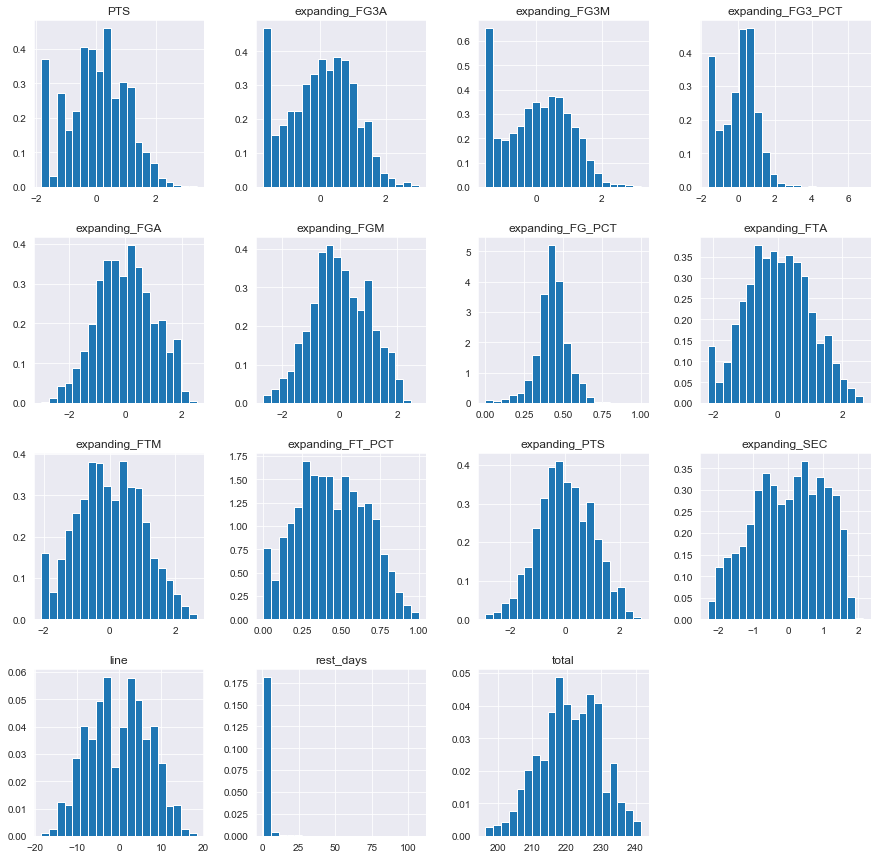

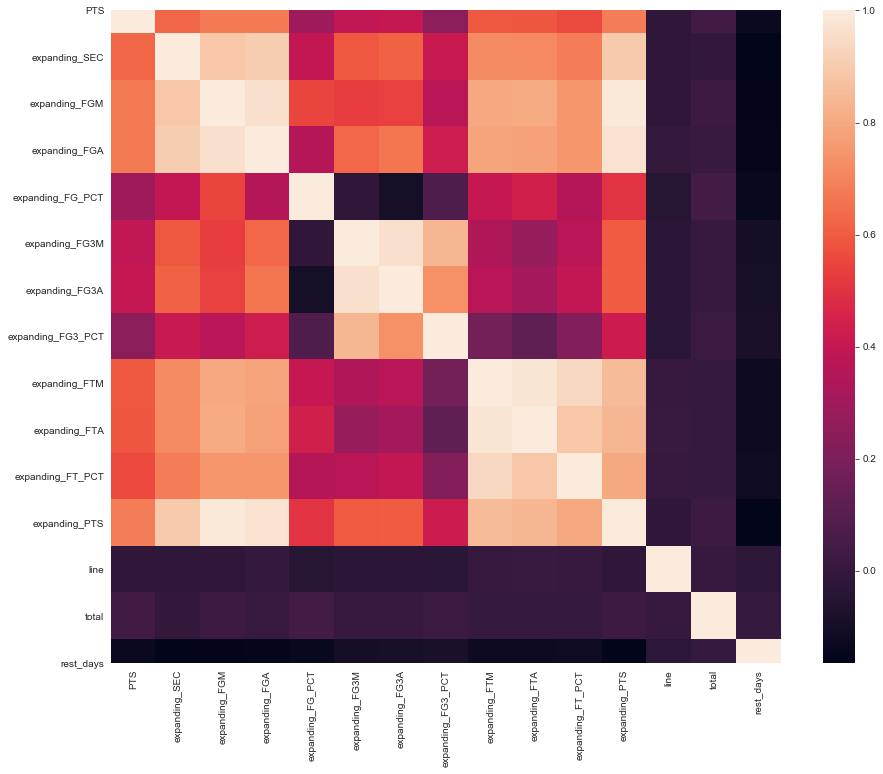

In [205]:
do_regression(pre_transform, ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS'])

In [168]:
train = pre_transform.iloc[:train_size, :]
test = pre_transform.iloc[:test_size, :]

In [169]:
train.shape[0]+ test.shape[0]

25054

### Transform training variable to be more normal

In [170]:
pre_transform.columns

Index(['PTS', 'expanding_SEC', 'expanding_FGM', 'expanding_FGA',
       'expanding_FG_PCT', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FTM', 'expanding_FTA',
       'expanding_FT_PCT', 'expanding_PTS', 'line', 'total', 'site', 'date',
       'rest_days'],
      dtype='object')

In [171]:
train_expanding_only = train.copy()

variables_to_transfrom = ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS']

scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
train_expanding_only[variables_to_transfrom] = scaler.fit_transform(train[variables_to_transfrom])


/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



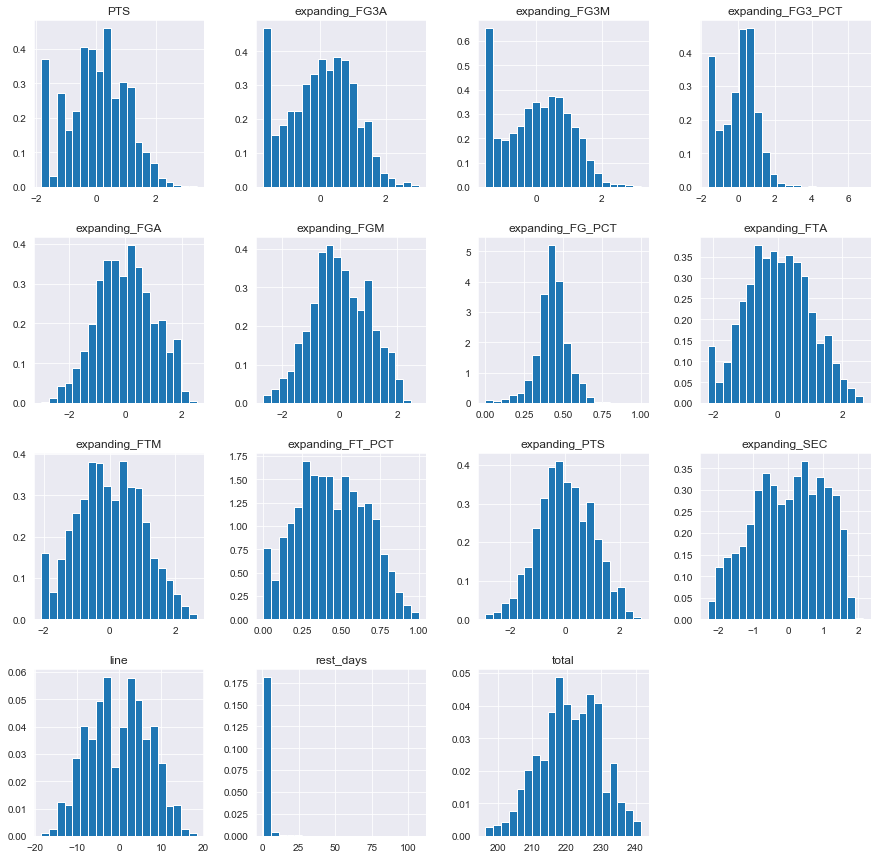

In [172]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
train_expanding_only.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);


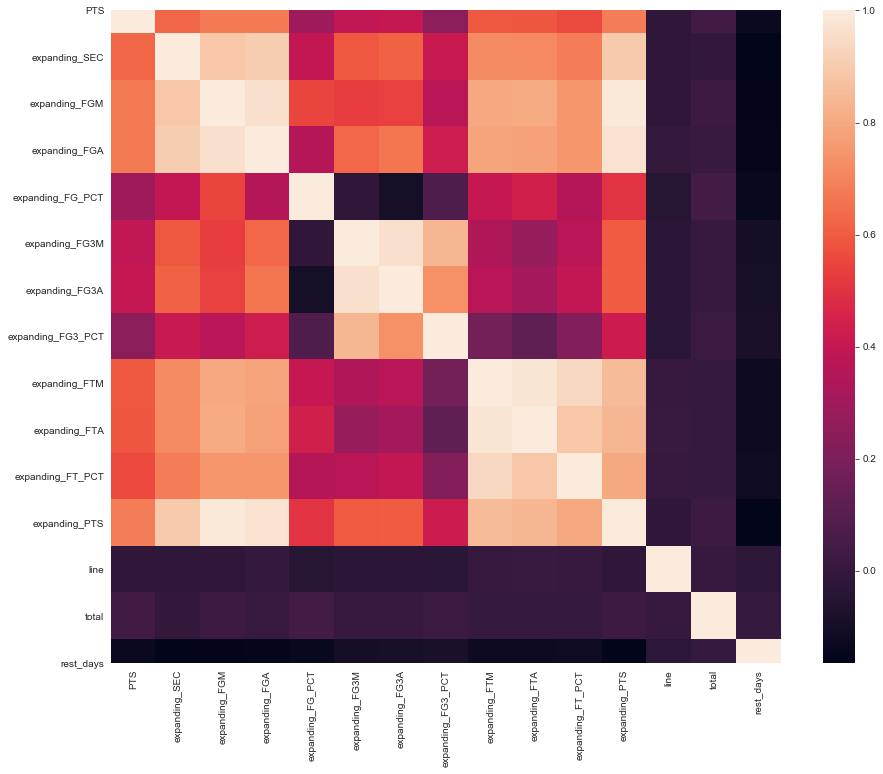

In [173]:
corr_train = train_expanding_only.corr()
fig = plt.figure(figsize = (15, 12))
ax = fig.gca()
sns.heatmap(corr_train, ax = ax)

In [174]:
outcome = 'PTS'
predictors = train_expanding_only.drop(labels=['PTS', 'date'], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [175]:
formula

'PTS~expanding_SEC+expanding_FGM+expanding_FGA+expanding_FG_PCT+expanding_FG3M+expanding_FG3A+expanding_FG3_PCT+expanding_FTM+expanding_FTA+expanding_FT_PCT+expanding_PTS+line+total+site+rest_days'

In [176]:
model = ols(formula=formula, data=train_expanding_only.drop('date', axis=1)).fit()

In [177]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.475     
Dependent Variable: PTS              AIC:                36649.1287
Date:               2020-01-15 16:52 BIC:                36772.7022
No. Observations:   16703            Log-Likelihood:     -18309.   
Df Model:           15               F-statistic:        1009.     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.476            Scale:              0.52484   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.2092   0.1558 -1.3433 0.1792 -0.5146  0.0961
site[T.home]         0.0215   0.0122  1.7594 0.0785 -0.0025  0.0455
expanding_SEC        0.0740   0.0138  5.3433 0.0000  0.0468  0.1011
expanding_FGM        0.5534   0.0926  5.9764 0.0000  0.3719  0.7349
expanding_FGA       -0.1433   0.0484 -2.9635 0.0030 -0.2381 -0.0485
expanding_FG_PCT    -1.0812   0.1179 -9.1724 0.0000 -1.3123 -0.8502
expanding_FG3M      -0.0238   0.0381 -0.6252 0.5319 -0.0986  0.0509
expanding_FG3A       0.0463   0.0316  1.4666 0.1425 -0.0156  0.1081
expanding_FG3_PCT   -0.0260   0.0127 -2.0564 0.0398 -0.0508 -0.0012
expanding_FTM        0.1233   0.0477  2.5852 0.0097  0.0298  0.2168
expanding_FTA       -0.0215   0.0325 -0.6620 0.5079 -0.0851  0.0421
expanding_FT_PCT    -0.0167   0.0812 -0.2062 0.8366 -0.1759  0.1424
expanding_PTS        0.1706   0.1161  1.4689 0.1419 -0.0570  0.3982
line                -0.0008   0.0009 -0.9309 0.3519 -0.0025  0.0009
total                0.0031   0.0006  4.8588 0.0000  0.0019  0.0044
rest_days           -0.0093   0.0016 -5.7864 0.0000 -0.0124 -0.0061
-------------------------------------------------------------------
Omnibus:              137.391       Durbin-Watson:          1.997  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       140.691
Skew:                 -0.225        Prob(JB):               0.000  
Kurtosis:             2.991         Condition No.:          6665   
===================================================================
* The condition number is large (7e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [178]:
test_expanding_only = test.copy()
test_expanding_only[variables_to_transfrom] = scaler.transform(test[variables_to_transfrom])

In [179]:
prediction = pd.DataFrame(model.predict(test_expanding_only))
merged = prediction.merge(test_expanding_only[['PTS']], left_on=prediction.index, right_on=test_expanding_only.index)
merged.index = merged['key_0']
merged.drop('key_0', axis=1, inplace=True)

In [180]:
test_expanding_only

PTS  expanding_SEC  expanding_FGM  expanding_FGA  \
9      0.173634       0.270981       0.071654       0.240242   
19375  0.173634      -0.463257       0.494247      -0.084419   
19376  1.882673       0.718761      -0.169357       0.136375   
19377 -0.522444      -0.712322      -0.436473      -0.202288   
19372  1.693636       0.524377      -0.169357       0.340274   
...         ...            ...            ...            ...   
9047   0.052970       0.294825       0.656233       0.450313   
16098  0.052970       0.606180       0.291626       0.498264   
3804   0.499795       1.400263       1.706120       1.839797   
292   -0.904083       0.078884      -0.063204       0.181382   
24269 -0.701549      -0.526522      -0.547597      -0.395112   

       expanding_FG_PCT  expanding_FG3M  expanding_FG3A  expanding_FG3_PCT  \
9              0.393000        0.727490        0.008046           2.611299   
19375          0.666500       -0.509429       -0.244688          -0.061394   
19376          0.366500        0.727490       -0.244688           4.170807   
19377          0.393000        0.195755       -0.244688          -0.061394   
19372          0.375000       -1.542221       -0.528066          -1.667433   
...                 ...             ...             ...                ...   
9047           0.512536       -0.031044        0.008046           0.216558   
16098          0.410034        1.125625        1.320946           0.434020   
3804           0.446737        0.378300        1.030446          -0.412481   
292            0.378107        0.659154        0.588223           0.715229   
24269          0.333692       -0.385223       -0.183951          -0.557201   

       expanding_FTM  expanding_FTA  expanding_FT_PCT  expanding_PTS  line  \
9          -0.276598      -0.607847          0.500000       0.080709  -9.0   
19375       0.579827       0.748564          0.333500       0.391812  -3.0   
19376       0.873317       0.502637          1.000000       0.162195  -3.0   
19377      -2.072044      -2.180756          0.000000      -0.585163  -3.0   
19372       1.491808       1.144192          1.000000       0.162195  -3.0   
...              ...            ...               ...            ...   ...   
9047        0.854302       0.812037          0.664929       0.621779   5.0   
16098       0.624153       0.651591          0.520414       0.468875  -5.5   
3804        1.327308       1.644215          0.593474       1.565995  -6.5   
292        -0.447424      -0.429427          0.366071      -0.053115  -2.0   
24269      -0.461307      -0.648814          0.384615      -0.576673   9.5   

       total  site       date  rest_days  
9      210.5  away 2018-10-20          1  
19375  219.0  away 2018-10-20          1  
19376  219.0  away 2018-10-20          1  
19377  219.0  away 2018-10-20          1  
19372  219.0  away 2018-10-20          1  
...      ...   ...        ...        ...  
9047   202.0  home 2018-12-15          1  
16098  205.5  away 2018-12-15          3  
3804   222.5  home 2018-12-15          1  
292    215.0  away 2018-12-15          1  
24269  211.0  away 2018-12-15          5  

[8351 rows x 17 columns]

In [181]:
y_pred_df = prediction.merge(test_expanding_only.drop('PTS', axis=1), 
                 left_on= prediction.index, right_on= test_expanding_only.index).set_index('key_0', drop=True)

In [183]:
y_pred_reg = y_pred_df.copy()

variables_to_transfrom = [0, 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS']
y_pred_reg[variables_to_transfrom] = scaler.inverse_transform(y_pred_df[variables_to_transfrom])

In [192]:
y_pred_reg.columns

Index([                  0,     'expanding_SEC',     'expanding_FGM',
           'expanding_FGA',  'expanding_FG_PCT',    'expanding_FG3M',
          'expanding_FG3A', 'expanding_FG3_PCT',     'expanding_FTM',
           'expanding_FTA',  'expanding_FT_PCT',     'expanding_PTS',
                    'line',             'total',              'site',
                    'date',         'rest_days'],
      dtype='object')

In [196]:
['PTS' if x == 0 else x for x in y_pred_reg.columns ]

['PTS',
 'expanding_SEC',
 'expanding_FGM',
 'expanding_FGA',
 'expanding_FG_PCT',
 'expanding_FG3M',
 'expanding_FG3A',
 'expanding_FG3_PCT',
 'expanding_FTM',
 'expanding_FTA',
 'expanding_FT_PCT',
 'expanding_PTS',
 'line',
 'total',
 'site',
 'date',
 'rest_days']

In [184]:
y_pred_reg

0  expanding_SEC  expanding_FGM  expanding_FGA  \
key_0                                                           
9       8.191649    1492.000000       3.500000       8.500000   
19375   9.563066    1121.000000       4.500000       7.000000   
19376   8.471687    1712.000000       3.000000       8.000000   
19377   4.891023     991.500000       2.500000       6.500000   
19372  10.130137    1617.000000       3.000000       9.000000   
...          ...            ...            ...            ...   
9047   11.829520    1503.821429       4.928571       9.571429   
16098  10.767048    1657.068966       4.000000       9.827586   
3804   21.563061    2039.736842       8.421053      18.947368   
292     8.012793    1396.285714       3.214286       8.214286   
24269   5.881020    1088.307692       2.307692       5.730769   

       expanding_FG_PCT  expanding_FG3M  expanding_FG3A  expanding_FG3_PCT  \
key_0                                                                        
9              0.393000        1.500000        2.500000           0.583500   
19375          0.666500        0.500000        2.000000           0.250000   
19376          0.366500        1.500000        2.000000           0.750000   
19377          0.393000        1.000000        2.000000           0.250000   
19372          0.375000        0.000000        1.500000           0.000000   
...                 ...             ...             ...                ...   
9047           0.512536        0.821429        2.500000           0.288536   
16098          0.410034        1.965517        6.034483           0.317931   
3804           0.446737        1.157895        5.105263           0.199632   
292            0.378107        1.428571        3.857143           0.355036   
24269          0.333692        0.576923        2.115385           0.178269   

       expanding_FTM  expanding_FTA  expanding_FT_PCT  expanding_PTS  line  \
key_0                                                                        
9           1.000000       1.000000          0.500000       9.500000  -9.0   
19375       2.000000       3.000000          0.333500      11.500000  -3.0   
19376       2.500000       2.500000          1.000000      10.000000  -3.0   
19377       0.000000       0.000000          0.000000       6.000000  -3.0   
19372       4.000000       4.000000          1.000000      10.000000  -3.0   
...              ...            ...               ...            ...   ...   
9047        2.464286       3.142857          0.664929      13.142857   5.0   
16098       2.068966       2.793103          0.520414      12.034483  -5.5   
3804        3.526316       5.736842          0.593474      21.526316  -6.5   
292         0.857143       1.178571          0.366071       8.714286  -2.0   
24269       0.846154       0.961538          0.384615       6.038462   9.5   

       total  site       date  rest_days  
key_0                                     
9      210.5  away 2018-10-20          1  
19375  219.0  away 2018-10-20          1  
19376  219.0  away 2018-10-20          1  
19377  219.0  away 2018-10-20          1  
19372  219.0  away 2018-10-20          1  
...      ...   ...        ...        ...  
9047   202.0  home 2018-12-15          1  
16098  205.5  away 2018-12-15          3  
3804   222.5  home 2018-12-15          1  
292    215.0  away 2018-12-15          1  
24269  211.0  away 2018-12-15          5  

[8351 rows x 17 columns]

In [185]:
test

PTS  expanding_SEC  expanding_FGM  expanding_FGA  expanding_FG_PCT  \
9      10.0    1492.000000       3.500000       8.500000          0.393000   
19375  10.0    1121.000000       4.500000       7.000000          0.666500   
19376  31.0    1712.000000       3.000000       8.000000          0.366500   
19377   5.0     991.500000       2.500000       6.500000          0.393000   
19372  28.0    1617.000000       3.000000       9.000000          0.375000   
...     ...            ...            ...            ...               ...   
9047    9.0    1503.821429       4.928571       9.571429          0.512536   
16098   9.0    1657.068966       4.000000       9.827586          0.410034   
3804   13.0    2039.736842       8.421053      18.947368          0.446737   
292     3.0    1396.285714       3.214286       8.214286          0.378107   
24269   4.0    1088.307692       2.307692       5.730769          0.333692   

       expanding_FG3M  expanding_FG3A  expanding_FG3_PCT  expanding_FTM  \
9            1.500000        2.500000           0.583500       1.000000   
19375        0.500000        2.000000           0.250000       2.000000   
19376        1.500000        2.000000           0.750000       2.500000   
19377        1.000000        2.000000           0.250000       0.000000   
19372        0.000000        1.500000           0.000000       4.000000   
...               ...             ...                ...            ...   
9047         0.821429        2.500000           0.288536       2.464286   
16098        1.965517        6.034483           0.317931       2.068966   
3804         1.157895        5.105263           0.199632       3.526316   
292          1.428571        3.857143           0.355036       0.857143   
24269        0.576923        2.115385           0.178269       0.846154   

       expanding_FTA  expanding_FT_PCT  expanding_PTS  line  total  site  \
9           1.000000          0.500000       9.500000  -9.0  210.5  away   
19375       3.000000          0.333500      11.500000  -3.0  219.0  away   
19376       2.500000          1.000000      10.000000  -3.0  219.0  away   
19377       0.000000          0.000000       6.000000  -3.0  219.0  away   
19372       4.000000          1.000000      10.000000  -3.0  219.0  away   
...              ...               ...            ...   ...    ...   ...   
9047        3.142857          0.664929      13.142857   5.0  202.0  home   
16098       2.793103          0.520414      12.034483  -5.5  205.5  away   
3804        5.736842          0.593474      21.526316  -6.5  222.5  home   
292         1.178571          0.366071       8.714286  -2.0  215.0  away   
24269       0.961538          0.384615       6.038462   9.5  211.0  away   

            date  rest_days  
9     2018-10-20          1  
19375 2018-10-20          1  
19376 2018-10-20          1  
19377 2018-10-20          1  
19372 2018-10-20          1  
...          ...        ...  
9047  2018-12-15          1  
16098 2018-12-15          3  
3804  2018-12-15          1  
292   2018-12-15          1  
24269 2018-12-15          5  

[8351 rows x 17 columns]

In [190]:
sqrt(mean_squared_error(test.PTS, y_pred_reg[0]))

5.931777754799309

In [189]:
sqrt(mean_squared_error(test.PTS, test.expanding_PTS))

5.9590763547667835

[0,
 'expanding_FG3M',
 'expanding_FG3A',
 'expanding_FG3_PCT',
 'expanding_FGM',
 'expanding_FGA',
 'expanding_FTM',
 'expanding_FTA',
 'expanding_SEC',
 'expanding_PTS']